In [1]:
from bs4 import BeautifulSoup
import re # RegEx
from lxml import etree
import pandas as pd
from cleantext import clean
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pandarallel import pandarallel

pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Import data

## mapping file

In [2]:
df_mapping = pd.read_csv("Data/mapping.csv")
df_out = df_mapping.copy()
df_mapping.head()

,date,CompanyName,at,bkvlps,ceq,dvt,gp,ni,revt,mkvalt,filename,Ticker
0,24-Jan-05 10:00pm GMT,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1002205_T.xml,AXP
1,24-Oct-05 9:00pm GMT,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1151089_T.xml,AXP
2,26-Apr-05 9:00pm GMT,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1055317_T.xml,AXP
3,25-Jul-05 9:00pm GMT,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1104071_T.xml,AXP
4,24-Apr-06 4:00pm GMT,American Express Co,127853.0,8.7665,10511.0,692.0,6088.0,3707.0,28710.0,72743.33,1157651_T.xml,AXP


adjust date format of date column

In [3]:
df_mapping['date'] = pd.to_datetime(df_mapping['date'])

## import xml files & get soup

In [4]:
# create workfile 
df_workfile = df_mapping.copy()
df_workfile['raw_body'] = np.nan

In [5]:
# specify the filenames that should be included in the analysis
filenames = df_mapping['filename']
len(filenames)

2029

loop through the filenames and read in the transcripts. Then convert the xml to a soup object and get the raw text and save it in workfile.

In [6]:

for filename in filenames:
    
    # read the file and convert the xml into a soup object
    tree = etree.parse("Data/Calls/" + filename)
    soup = BeautifulSoup(etree.tostring(tree.getroot()), "lxml-xml")

    # use the body tag of the XML / body attribute of soup object to get the earnings call transcript
    body_text = soup.Body.get_text(separator=" ")

    # save the raw body text in the dataframe
    df_workfile.loc[df_workfile['filename'] == filename, 'raw_body'] = body_text


drop all calls that are not included

In [7]:
df_workfile = df_workfile[~df_workfile['raw_body'].isna()]
df_workfile = df_workfile.reset_index(drop=True)
df_workfile.shape

(2029, 13)

As we see, no call was dropped.

In [8]:
df_workfile.head(3)

,date,CompanyName,at,bkvlps,ceq,dvt,gp,ni,revt,mkvalt,filename,Ticker,raw_body
0,2005-01-24 22:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1002205_T.xml,AXP,Q4 2004 American Express Company Earnings Conf...
1,2005-10-24 21:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1151089_T.xml,AXP,Q3 2005 American Express Company Earnings Conf...
2,2005-04-26 21:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1055317_T.xml,AXP,Q1 2005 American Express Company Earnings Conf...


check if the raw body texts have been added to the df correctly

In [9]:
df_workfile.loc[0,'raw_body'][:5000]

"Q4 2004 American Express Company Earnings Conference Call\n\nNEW YORK Jan 25, 2005 (Thomson StreetEvents) -- Edited Transcript of American Express Co earnings conference call or presentation Monday, January 24, 2005 at 10:00:00pm GMT\n\nTEXT version of Transcript\n\n================================================================================\nCorporate Participants\n================================================================================\n   *  Ron Stovall\n      American Express Company - Vice President Investor Relations\n   *  Gary Crittenden\n      American Express Company - Executive Vice President, CFO\n\n================================================================================\nConference Call Participants\n================================================================================\n   *  Michael Cohen\n      Susquehanna Financial Group - Analyst\n   *  David Hochstim\n      Bear, Stearns &amp; Company - Analyst\n   *  Eric Wasserstrom\n      UBS Warburg

# Cleaning
Do you see a need for data cleaning?

Yes. As we see in the string printed above, at the stage when we read the text from the xml, the text is very raw. For example, texts include:
- at the beginning of each xml body there is an introduction who is attending the call. These parts need to be dropped as they distort our analysis
- the parts where it is announced who is speaking. As this is added afterward and these passages were not said by anyone nor contain any valuable information, these part should be dropped
- we have a lot of "----.." parts that contain no information for our textual analysis and should be dropped
- we have a lot of double spaces, line breaks ("\n") etc. Need to be dropped
- there are currency symbols, digits, numbers, e-mail adresses etc. These should also be dropped

In the cleaning section below, I will tackle all of these problems.

## regex and clean-text

### clean most basic components...
double spaces, line breaks etc..

In [10]:
df_workfile['text'] = df_workfile['raw_body'].parallel_apply(lambda x: re.sub('-?(\n|\r|\t)',' ',x))   # |=|-
df_workfile['text'] = df_workfile['text'].parallel_apply(lambda x: re.sub(' +', ' ', x))

In [11]:
df_workfile.head(3)

,date,CompanyName,at,bkvlps,ceq,dvt,gp,ni,revt,mkvalt,filename,Ticker,raw_body,text
0,2005-01-24 22:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1002205_T.xml,AXP,Q4 2004 American Express Company Earnings Conf...,Q4 2004 American Express Company Earnings Conf...
1,2005-10-24 21:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1151089_T.xml,AXP,Q3 2005 American Express Company Earnings Conf...,Q3 2005 American Express Company Earnings Conf...
2,2005-04-26 21:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1055317_T.xml,AXP,Q1 2005 American Express Company Earnings Conf...,Q1 2005 American Express Company Earnings Conf...


## seperate the data from the presentation and the Q&A

In [12]:
# pre-define the columns
df_workfile['presentation'] = np.nan
df_workfile['Q&A'] = np.nan

The for loop below loops through all calls (rows of workfile) and seperates the presentation from the Q&A, based on a regex pattern. The texts will then be stored in the dataframe columns created above. If the call only contains a presentation and no Q&A, the Q&A will be saved as NaN. 

In [13]:
count = 0  # counter variable for exception block below (counts the cases where neither presentation nor Q&A could be extracted)
for i in range(len(df_workfile)):

    # get filename for logging purpose
    filename = df_workfile.loc[i, 'filename']

    # get text from dataframe
    text = df_workfile.loc[i, 'text']
    
    # split the earnings call on regex. Use that the pattern with =(whitespace)Presentation and =(whitespace)Question and Answers appears 
    # only at the beginning of every presentations / Q&A section
    li = re.split('=\sPresentation |=\sQuestions and Answers', text)

    # try except block tries to guarantee that every piece of information is saved in workfile
    try:
        # first try to save both presentation and Q&A section
        df_workfile.loc[i, 'presentation'] = li[1]  # presentation
        df_workfile.loc[i, 'Q&A'] = li[2]    # Q&A  
    except Exception:
        # Exception occurrs if there was no Q&A section
        try:
            # try to save only the presentation section
            df_workfile.loc[i, 'presentation'] = li[1]  # presentation
            df_workfile.loc[i, 'Q&A'] = np.nan    # Q&A  
        except Exception:
            # case that nothing of both could be saved. Save NaN
            df_workfile.loc[i, 'presentation'] = np.nan  # presentation
            df_workfile.loc[i, 'Q&A'] = np.nan    # Q&A  
            print('Crash for ', filename)
            count += 1
        continue
print(count)

0


At this stage, the first basic parts of text cleaning have been done, and we seperated the presentation from the Q&A. In the plot below I would like to illustrate how many conference calls did not contain an Q&A sessions. Moreover one can also see if there are any other NaN problems in the dataset.

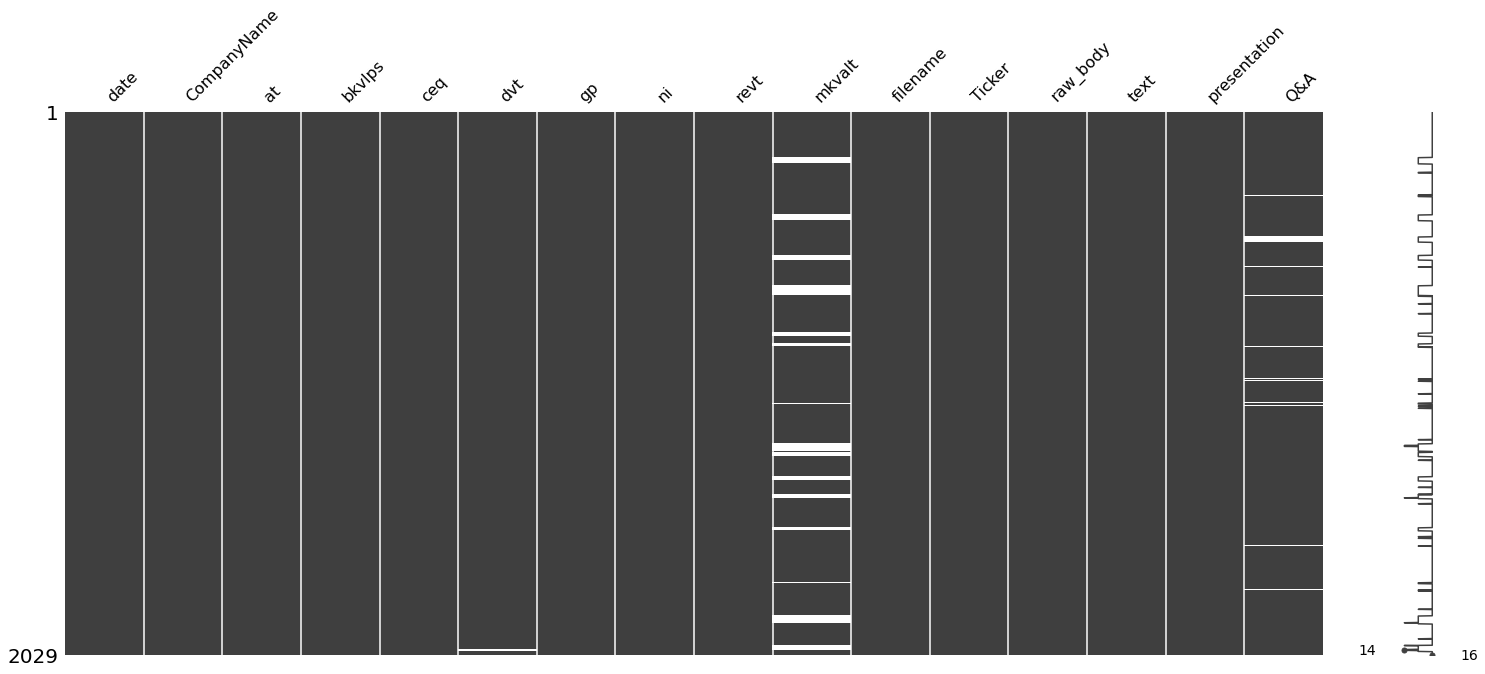

In [14]:
import missingno as msno
msno.matrix(df_workfile);

After splitting the whole xml body in the parts from presentation and Q&A, we will extract the main contents (parts where participants actually speak) from the raw text body. The parts that define who is speaking will be dropped.

In [15]:
def get_text_parts(text):
    """This function takes in a text (Presentation part or Q&A part) on a very raw level. The pattern '--+' will be used in order to extract only the parts of the 
    transcript that contain text that was said by a participant in the call. Any additional text will be dropped (like the description who is speaking etc.).

    This is done by splitting the text at every occurrance of '------...' and filtering for the parts that do not include the pattern '\[[1-9]*]'.

    Args:
        text ([string]): Presentation part or Q&A part on a very raw level

    Returns:
        [string]: cleaned text
    """

    # split text to list on regex
    splitted_text = re.split(r'--+', text)

    # filter the list on condition that does not single string do not contain regex pattern
    filtered_parts = list(filter(lambda x: not re.search('\[[0-9]\d*]', x), splitted_text))

    # join the list back to a text
    text_joined = " ".join(text_part for text_part in filtered_parts)

    return text_joined
    

In [16]:
# apply the function to all texts
df_workfile['presentation'] = df_workfile['presentation'].parallel_map(lambda x: get_text_parts(x))
df_workfile['Q&A'] = df_workfile['Q&A'].parallel_map(lambda x: np.nan if pd.isnull(x) else get_text_parts(x))

In [17]:
# Overwrite 'text' column with with the joined parts from the presentation and Q&A
df_workfile['text'] = df_workfile.apply(lambda x: ' '.join([x['presentation'], x['Q&A']]) if not pd.isnull(x['Q&A']) else x['presentation'], axis=1)

In [18]:
df_workfile[['text', 'presentation', 'Q&A']].head()

,text,presentation,Q&A
0,Good afternoon. My name is Miles and I will ...,Good afternoon. My name is Miles and I will ...,Thank you. We will now begin the question-a...
1,"Good afternoon. My name is Derek, and I will...","Good afternoon. My name is Derek, and I will...","(OPERATOR INSTRUCTIONS). Bruce Harting, Leh..."
2,"At this time, I would like to welcome everyo...","At this time, I would like to welcome everyo...","(OPERATOR INSTRUCTIONS). Michael Cohen, Sus..."
3,Good afternoon. My name is Michael and I wil...,Good afternoon. My name is Michael and I wil...,"(OPERATOR INSTRUCTIONS) Michael Hodes, Gold..."
4,At this time I would like to welcome everyon...,At this time I would like to welcome everyon...,Thank you. [OPERATOR INSTRUCTIONS]. First q...


### text cleaner
With the text cleaner function below it is very convenient to perform a range of different cleaning functions on all texts.

In [19]:
def text_cleaner(text):
    return clean(text,
        fix_unicode=True,               # fix various unicode errors
        to_ascii=True,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                  # replace all URLs with a special token
        no_emails=True,                # replace all email addresses with a special token
        no_phone_numbers=True,         # replace all phone numbers with a special token
        no_numbers=True,               # replace all numbers with a special token
        no_digits=True,                # replace all digits with a special token
        no_currency_symbols=True,      # replace all currency symbols with a special token
        no_punct=False,                 # remove punctuations
        replace_with_punct="",          # instead of removing punctuations you may replace them
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        lang="en"                       # set to 'de' for German special handling
    )

In [20]:
df_workfile['text'] = df_workfile['text'].parallel_map(lambda x: text_cleaner(x))
df_workfile['presentation'] = df_workfile['presentation'].parallel_map(lambda x: text_cleaner(x))
df_workfile['Q&A'] = df_workfile['Q&A'].parallel_map(lambda x: text_cleaner(x) if not pd.isnull(x) else np.nan)

In [21]:
# workfile
df_workfile.loc[0, 'text'][:500]

"good afternoon. my name is miles and i will be your conference facilitator today. at this time i would like to welcome everyone to the american express fourth quarter and year-end earnings conference call. all lines have been placed on mute to prevent any background noise. after the speaker's remarks, there will be a question-and-answer period. at that time, [audio difficulties] using your telephone keypad, you will be able to ask a question. i would now like to turn the call over to our host, m"

# Wordcloud

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_texts = " ".join(text for text in df_workfile['text'])

In [23]:
# Generate a word cloud image
wordcloud = WordCloud().generate(all_texts)

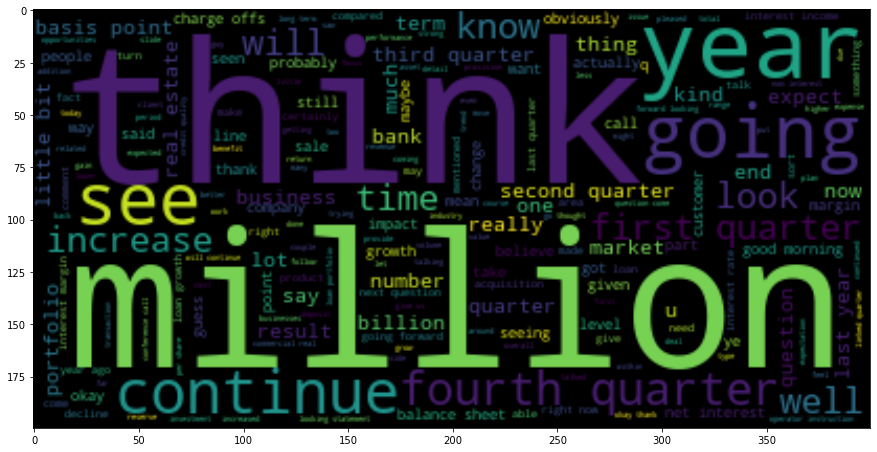

In [24]:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

# Define "helper" data...
... aka sets and dataframes that will be used at different points in the NB.

### failed banks

In [25]:
failed = {'FMCC', 
        'IBCP', 
        'IDMCQ', 
        'LEHMQ', 
        'UCBHQ', 
        'WAFD', 
        'FNMA'
        }

In [26]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

# Do you see a pattern in length of presentations and Q&As based on the banks’ profitability?
The question asks if there is a tendency that the presentations share increases (decreases) with lower (higher) profitability. The rational is that we would like to see if the management tends to spend more time on the presentation (thus limiting the lenght of the Q&A session) when the reported profitability for the period that is discussed in the call is low.

## fill the output dataframe to perform analysis

In [27]:
# form a ratio of how much characters have been attributable to the presentation vs. the total lenght of the call
df_workfile['presentation share'] = df_workfile.apply(lambda row: len(row['presentation']) / (len(row['Q&A']) + len(row['presentation'])) if not pd.isnull(row['Q&A'])
            else 1, axis=1)

## plot profitability over time
In the plots below it is glaring that during the financial crisis (07,08) the profitabilitiy of the banks included in out dataset decreased significantly.

In [28]:
# calculate the proditability as the net margin (Net income / Revenue)
df_workfile['profitability'] = df_workfile['ni'] / df_workfile['revt']

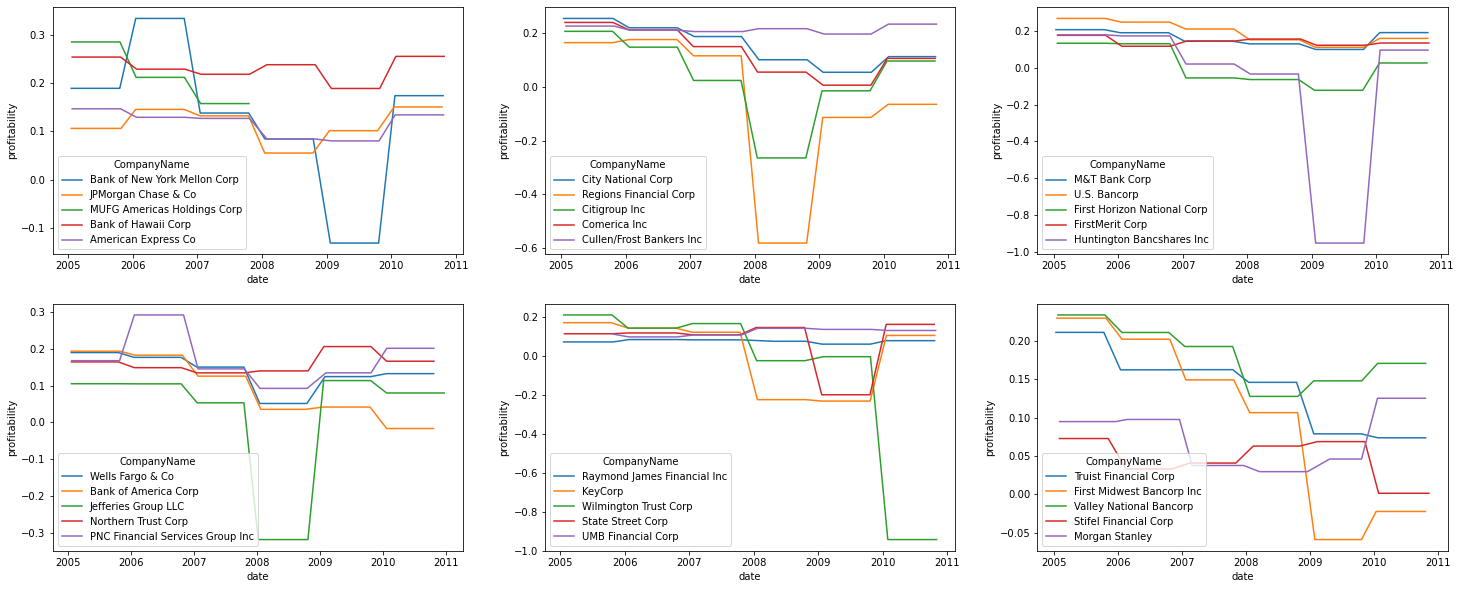

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

base_tickers = [ticker for ticker in list(df_workfile['Ticker'].unique()) if ticker not in failed]
tickers1 = base_tickers[:5]
tickers2 = base_tickers[5:10]
tickers3 = base_tickers[10:15]
tickers4 = base_tickers[15:20]
tickers5 = base_tickers[20:25]
tickers6 = base_tickers[25:30]

df_plot1 = df_workfile[df_workfile['Ticker'].isin(tickers1)].sort_values('date')
df_plot2 = df_workfile[df_workfile['Ticker'].isin(tickers2)].sort_values('date')
df_plot3 = df_workfile[df_workfile['Ticker'].isin(tickers3)].sort_values('date')
df_plot4 = df_workfile[df_workfile['Ticker'].isin(tickers4)].sort_values('date')
df_plot5 = df_workfile[df_workfile['Ticker'].isin(tickers5)].sort_values('date')
df_plot6 = df_workfile[df_workfile['Ticker'].isin(tickers6)].sort_values('date')

sns.lineplot(data=df_plot1, x='date', y='profitability', hue='CompanyName', ax=axs[0, 0]);
sns.lineplot(data=df_plot2, x='date', y='profitability', hue='CompanyName', ax=axs[0, 1]);
sns.lineplot(data=df_plot3, x='date', y='profitability', hue='CompanyName', ax=axs[0, 2]);
sns.lineplot(data=df_plot4, x='date', y='profitability', hue='CompanyName', ax=axs[1, 0]);
sns.lineplot(data=df_plot5, x='date', y='profitability', hue='CompanyName', ax=axs[1, 1]);
sns.lineplot(data=df_plot6, x='date', y='profitability', hue='CompanyName', ax=axs[1, 2]);


In the next plot, the presentation share per entity is illustrated over time. While the decline in profitability is very good to see, it is harder to see a clear development in the presentations share. But nevertheless this does not mean that there exists no relationship / pattern between the variables...

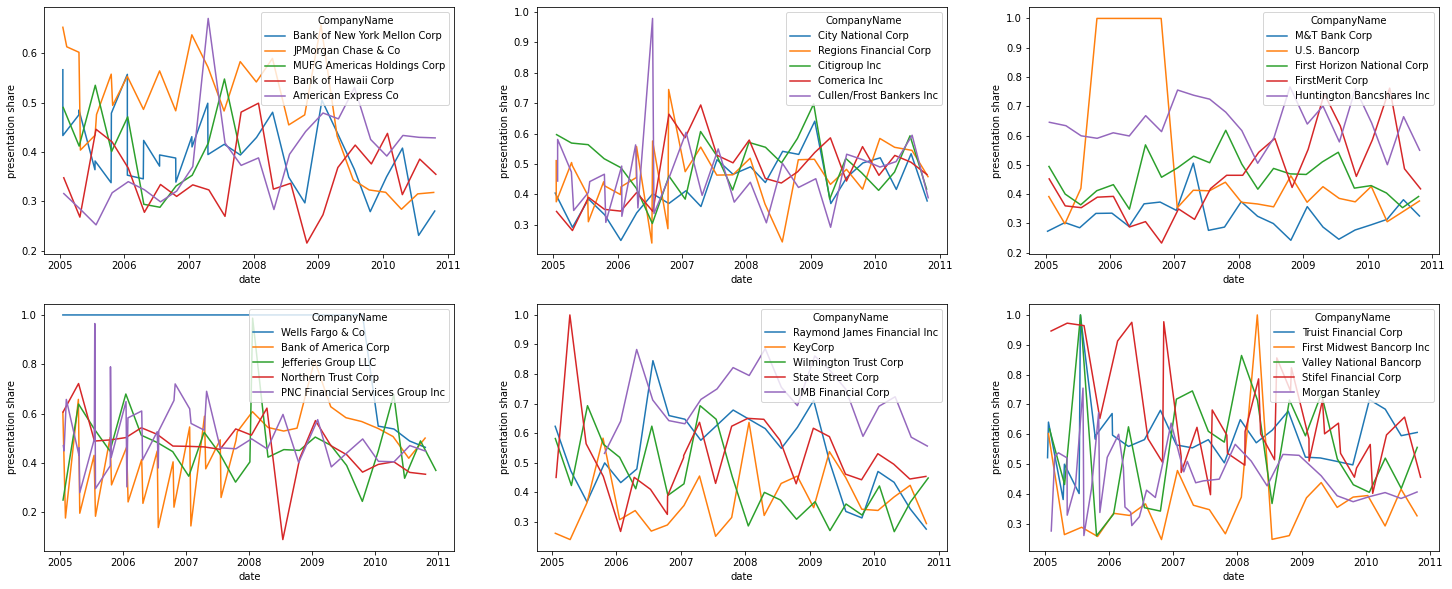

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

base_tickers = [ticker for ticker in list(df_workfile['Ticker'].unique()) if ticker not in failed]
tickers1 = base_tickers[:5]
tickers2 = base_tickers[5:10]
tickers3 = base_tickers[10:15]
tickers4 = base_tickers[15:20]
tickers5 = base_tickers[20:25]
tickers6 = base_tickers[25:30]

df_plot1 = df_workfile[df_workfile['Ticker'].isin(tickers1)].sort_values('date')
df_plot2 = df_workfile[df_workfile['Ticker'].isin(tickers2)].sort_values('date')
df_plot3 = df_workfile[df_workfile['Ticker'].isin(tickers3)].sort_values('date')
df_plot4 = df_workfile[df_workfile['Ticker'].isin(tickers4)].sort_values('date')
df_plot5 = df_workfile[df_workfile['Ticker'].isin(tickers5)].sort_values('date')
df_plot6 = df_workfile[df_workfile['Ticker'].isin(tickers6)].sort_values('date')

sns.lineplot(data=df_plot1, x='date', y='presentation share', hue='CompanyName', ax=axs[0, 0]);
sns.lineplot(data=df_plot2, x='date', y='presentation share', hue='CompanyName', ax=axs[0, 1]);
sns.lineplot(data=df_plot3, x='date', y='presentation share', hue='CompanyName', ax=axs[0, 2]);
sns.lineplot(data=df_plot4, x='date', y='presentation share', hue='CompanyName', ax=axs[1, 0]);
sns.lineplot(data=df_plot5, x='date', y='presentation share', hue='CompanyName', ax=axs[1, 1]);
sns.lineplot(data=df_plot6, x='date', y='presentation share', hue='CompanyName', ax=axs[1, 2]);


## regression analysis
... that's why I will run a regression on the data that has been derived in the previous section to further investigate the relationship between the variables.

In [31]:
import statsmodels.api as sm

First of all, we need to check if the data needs further preprocessing: 
- Check for the necessity to cancel some outlier values in profitability (as they can distort regression line fit)
- Cancel rows / calls that did not contain a Q&A session

In [32]:
X_regression = df_workfile.copy()

# delete calls without Q&A Session
X_regression = X_regression[~X_regression['Q&A'].isna()]

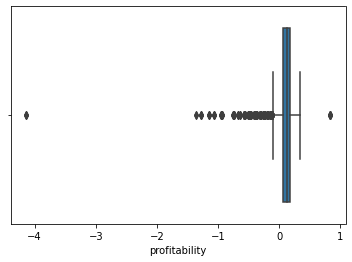

In [33]:
# Preprocessing - cancel outliers
sns.boxplot(data=X_regression, x='profitability');

In [34]:
def preprocess_data(df):
    """This function takes in a dataframe containing the data that will be used to run the regression analysis below. "Outliers" in the column profitability will be 
       canceled. The process here is extremely basic and depends on deriving fences in which profitability values need to be, based on self-determined percentile 
       ranks.

    Args:
        df ([dataframe]): dataframe containing the preprocessed data.
    """
    # get the lower & upper 15 percentile
    Q1 = df["profitability"].quantile(0.15)
    Q3 = df["profitability"].quantile(0.85)
    IQR = Q3 - Q1

    # derive fences in which the values need to be in order to be included in regression
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    print('lower fence', lower_fence)
    print('upper fence',upper_fence)
    print(str(df[((df["profitability"] < lower_fence) |(df["profitability"] > upper_fence))].shape[0]), ' rows dropped...')
    
    # cancel outliers
    df_preprocessed = df[~((df["profitability"] < lower_fence) |(df["profitability"] > upper_fence))]
    
    return df_preprocessed

lower fence -0.32425053685726035
upper fence 0.5248898343319574
110  rows dropped...


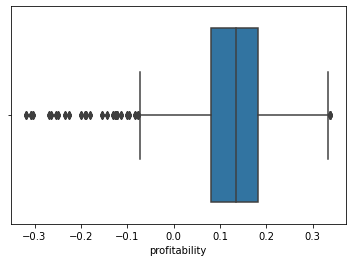

In [35]:
# preprocess the data 
X_preprocessed = preprocess_data(X_regression)
# plot the distribution of variable "profitability" after cleaning
sns.boxplot(data=X_preprocessed, x='profitability');

In [36]:
# define the input variables for the regression
X = X_preprocessed['presentation share']
y = X_preprocessed['profitability']
X = sm.add_constant(X)

run regression and print summary

In [37]:
results = sm.OLS(y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          profitability   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     62.20
Date:                Sat, 29 Jan 2022   Prob (F-statistic):           5.24e-15
Time:                        16:55:43   Log-Likelihood:                 1546.4
No. Observations:                1866   AIC:                            -3089.
Df Residuals:                    1864   BIC:                            -3078.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1799      0.008     21.768      0.000       0.164       0.196
presentation share    -0.1343      0.017     -7.887      0.000      -0.168      -0.101
==============================================================================
Omnibus:                      474.907   Durbin-Watson:                   0.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1267.470
Skew:                          -1.335   Prob(JB):                    5.92e-276
Kurtosis:                       6.028   Cond. No.                         8.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

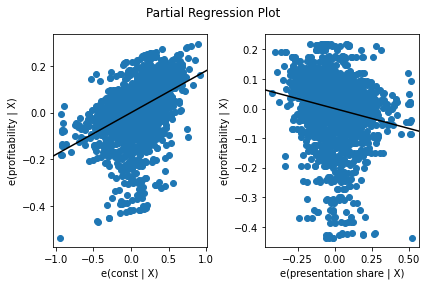

In [38]:
fig = sm.graphics.plot_partregress_grid(results)
fig.tight_layout(pad=1.0)

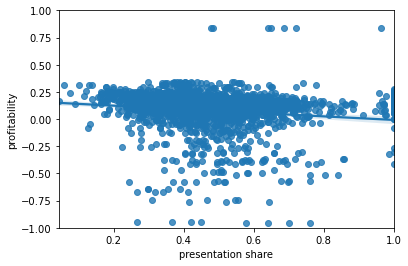

In [39]:
# Return relationship
sns.regplot(x='presentation share',y='profitability', data=df_workfile);
plt.ylim(-1, 1);

### Regression Results:
The regression shows a negative association of the presentations share and the profitability. This means that our guess guess in the beginning (presentation share tends to be higher when profitability is lower) is supported by our dataset, as slope coefficient is negative. Moreover the relationship between the variables presentations share and profitability is statistically significant (P>|t| = 0.000 for slope coefficient of presentations share).

# sentiment analysis

Different ways to derive sentiment from text file:
- Rule-Based sentiment analysis
    - uses a dictionary of words labelled by sentiment to determine the sentiment of a sentence
    - scores need to be combined with additional rules to mitigate sentences containing negations, sarcasm, or dependent clauses
- Machine Learning (ML) based sentiment analysis
    - ML model to recognize the sentiment based on the words and their order using a sentiment-labelled training set

In the section below I will try to measure the sentiment of single conference call based on the vocabulary used (dictionary counting), thus perform a rule-based sentiment analysis. I will use the Loughran & McDonald dictionary that we already discussed in class.

During my work on the case study, I also used diverse pre-trained ML models to classify the text / measure the polarity (i.e. BlobText, vader). I did not include them due to a highly inferior performance, both on a logical level and also when it comes to performance. 

## import resources

In [40]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/lukas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Loughran & McDonald dictionary

In [41]:
LM = pd.read_csv('https://www.dropbox.com/s/j35hfdxfy01ihio/LoughranMcDonald_MasterDictionary_2020.csv?dl=1')
LM.head()

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity,Syllables,Source
0,AARDVARK,1,312,1.422050e-08,1.335201e-08,3.700747e-06,96,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.367356e-10,8.882163e-12,9.362849e-09,1,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,4.102067e-10,1.200533e-10,5.359747e-08,7,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,15,6.836779e-10,4.080549e-10,1.406914e-07,14,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8009,3.650384e-07,3.798698e-07,3.523914e-05,1058,0,0,0,0,0,0,0,0,3,12of12inf


In [42]:
Negative = list(LM[LM['Negative']!=0]['Word'].apply(lambda x: x.lower()))
Negative[:10]

['abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abandonments',
 'abandons',
 'abdicated',
 'abdicates',
 'abdicating',
 'abdication']

In [43]:
Positive = list(LM[LM['Positive']!=0]['Word'].apply(lambda x: x.lower()))
Positive[:10] 

['able',
 'abundance',
 'abundant',
 'acclaimed',
 'accomplish',
 'accomplished',
 'accomplishes',
 'accomplishing',
 'accomplishment',
 'accomplishments']

In [44]:
# change the data structure of the LM dictionary to a python dict
sentiment_dict = { sentiment: list(LM[LM[sentiment]!=0]['Word'].apply(lambda x: x.lower())) for sentiment in ['Positive', 'Negative']}
sentiment_dict['Positive'][:10]

['able',
 'abundance',
 'abundant',
 'acclaimed',
 'accomplish',
 'accomplished',
 'accomplishes',
 'accomplishing',
 'accomplishment',
 'accomplishments']

In [45]:
df_workfile.loc[0, 'text'][:1500]

"good afternoon. my name is miles and i will be your conference facilitator today. at this time i would like to welcome everyone to the american express fourth quarter and year-end earnings conference call. all lines have been placed on mute to prevent any background noise. after the speaker's remarks, there will be a question-and-answer period. at that time, [audio difficulties] using your telephone keypad, you will be able to ask a question. i would now like to turn the call over to our host, mr. ron stovall. thank you. mr. stovall, you may begin your conference, sir. okay. thank you, miles and welcome to everyone. appreciate all of you joining us for today's discussion. before we get started, it's my job to remind you that the discussion today contains certain forward-looking statements about the company's future financial performance and business prospects, which are subject to risks and uncertainties and speak only as of today. the words believe, expect, anticipate, optimistic, in

## Dictionary counting with negation
In the section below, I will define a function that takes in a sentiment dictionary and a text and returns some sentiment measures. The function will consider negations for positive words. I will use the function on every conference call included in the dataframe.

In [46]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, conference_call):
    """Count positive and negative words with negation check. Account for simple negation only for positive words.
    A negation is observed if one of negate words occurrs within three words preceding a positive words.

    Args:
        dict ([dictionary]): contains the sentiment (here positive/negative) as keys and the words from a wordlist (here LM dictionary) that map to
                             this sentiment as values
        conference_call ([string]): text of one conference call

    Returns:
        [list]: contains the sentiment measures for the given conference call
    """
      
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
    
    # simple tokenization
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', conference_call.lower())
    word_count = len(input_words)
    
    # loop trough all words in the text and count occurrences of words associated with a certain sentiment 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [47]:
# call the function for every text in workfile
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in tqdm(df_workfile['text'], total=df_workfile.shape[0])]
# convert to panads df
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
#concat workfile and dataframe from function
train_tone_df = pd.concat([df_workfile, tone_lmdict_df.reindex(df_workfile.index)], axis=1)
train_tone_df.head(3)


,date,CompanyName,at,bkvlps,ceq,dvt,gp,ni,revt,mkvalt,...,presentation,Q&A,presentation share,profitability,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,2005-01-24 22:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,...,good afternoon. my name is miles and i will be...,thank you. we will now begin the question-and-...,0.315667,0.146679,0.840246,9283,190,112,"[good, able, optimistic, opportunity, enhance,...","[question, difficulties, question, questions, ..."
1,2005-10-24 21:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,...,"good afternoon. my name is derek, and i will b...","(operator instructions). bruce harting, lehman...",0.317339,0.146679,0.244998,9796,132,108,"[good, optimistic, opportunity, strong, achiev...","[question, questions, questions, question, aga..."
2,2005-04-26 21:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,...,"at this time, i would like to welcome everyone...","(operator instructions). michael cohen, susque...",0.284373,0.146679,0.603210,9781,160,101,"[able, optimistic, opportunity, strong, benefi...","[question, alerted, question, questions, quest..."


## plot tone of earnings calls over time
The plots below show the sentiment scores of earnings calls over time, grouped on a single entity level. Despite the measure of sentiment that I used in this section (dictionary count) is noisy by nature, one can easily see a change in the sentiment of earnings calls from the time before the GFC and during the GFC. The stark decline begins in the most cases at the start of 2008. During 2008 and 2009 one can see that the sentiment is depressed and reaches a low. In the years after the sentiment recovers near the pre-crisis levels. To me this is in-line with the development of the GFC.

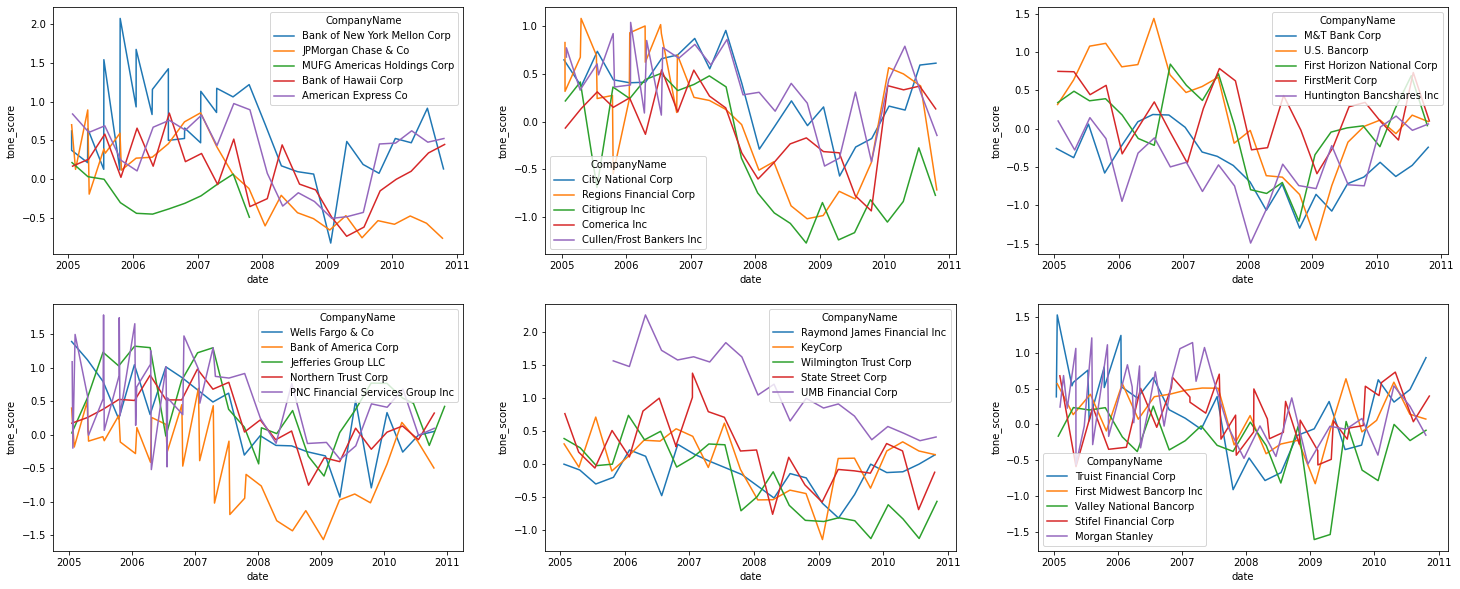

In [48]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

base_tickers = [ticker for ticker in list(train_tone_df['Ticker'].unique()) if ticker not in failed]
tickers1 = base_tickers[:5]
tickers2 = base_tickers[5:10]
tickers3 = base_tickers[10:15]
tickers4 = base_tickers[15:20]
tickers5 = base_tickers[20:25]
tickers6 = base_tickers[25:30]

df_plot1 = train_tone_df[train_tone_df['Ticker'].isin(tickers1)].sort_values('date')
df_plot2 = train_tone_df[train_tone_df['Ticker'].isin(tickers2)].sort_values('date')
df_plot3 = train_tone_df[train_tone_df['Ticker'].isin(tickers3)].sort_values('date')
df_plot4 = train_tone_df[train_tone_df['Ticker'].isin(tickers4)].sort_values('date')
df_plot5 = train_tone_df[train_tone_df['Ticker'].isin(tickers5)].sort_values('date')
df_plot6 = train_tone_df[train_tone_df['Ticker'].isin(tickers6)].sort_values('date')

sns.lineplot(data=df_plot1, x='date', y='tone_score', hue='CompanyName', ax=axs[0, 0]);
sns.lineplot(data=df_plot2, x='date', y='tone_score', hue='CompanyName', ax=axs[0, 1]);
sns.lineplot(data=df_plot3, x='date', y='tone_score', hue='CompanyName', ax=axs[0, 2]);
sns.lineplot(data=df_plot4, x='date', y='tone_score', hue='CompanyName', ax=axs[1, 0]);
sns.lineplot(data=df_plot5, x='date', y='tone_score', hue='CompanyName', ax=axs[1, 1]);
sns.lineplot(data=df_plot6, x='date', y='tone_score', hue='CompanyName', ax=axs[1, 2]);


As expected, the decline in sentiment is especially pronounced for banks that have failed during the period. Their sentiment scores development over time can be seen in the following plot...

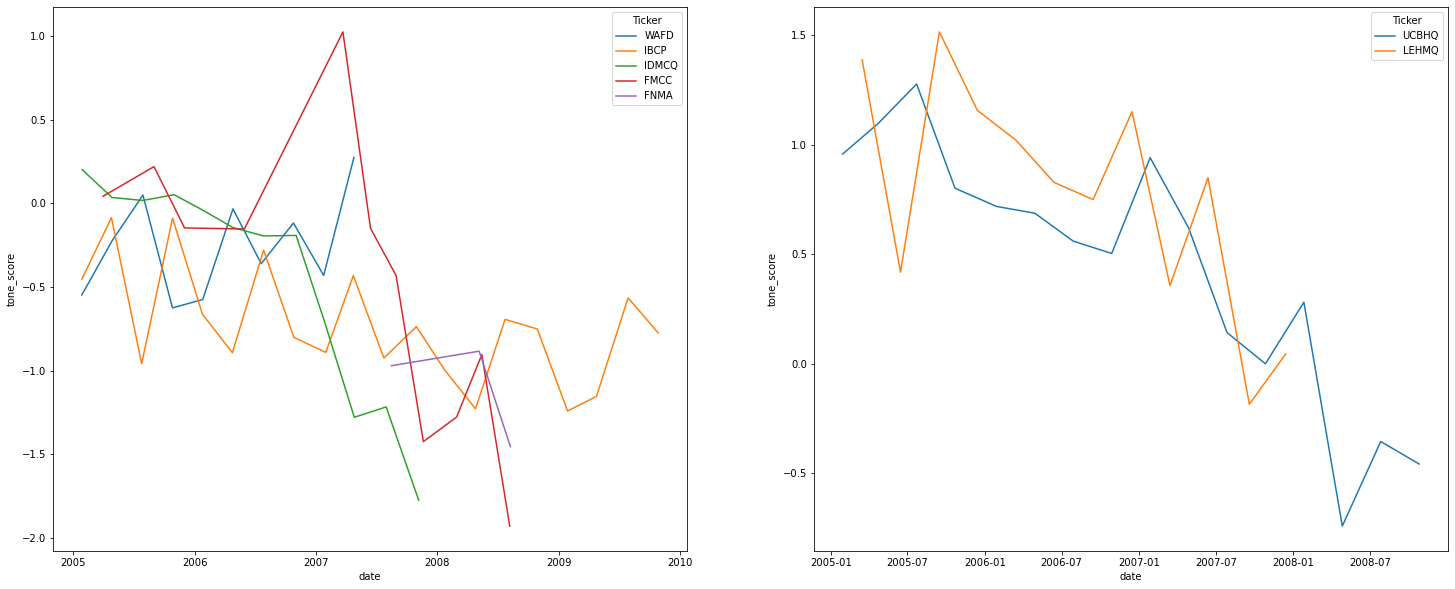

In [49]:
fig, axs = plt.subplots(ncols=2, figsize=(25, 10))

df_plot1 = train_tone_df[train_tone_df['Ticker'].isin(list(failed)[:5])].sort_values('date')
df_plot2 = train_tone_df[train_tone_df['Ticker'].isin(list(failed)[5:10])].sort_values('date')

sns.lineplot(data=df_plot1, x='date', y='tone_score', hue='Ticker', ax=axs[0]);
sns.lineplot(data=df_plot2, x='date', y='tone_score', hue='Ticker', ax=axs[1]);

# Association between Banks failure risk and their culture?
In order to give an appropriate answer to this question, again, a two-step process is necessary.
1) Measure corporate culture based on the earnings calls
2) Show associations between the culture metrics and the bank's failure risk

Getting more into detail on the process that I implemented here...

1) measure corporate culture
- To measure the corporate culture of banks I will again stick to a rule-based approach. Using dictionary counting with Li et al dictionary, I will derive scores for every call in each of the 5 dimensions proposed by Li et al.

- Moreover there are multiple ways to perform this rule-based approach (as discussed by Li et al):
    - 1: equally-weighted word count
    - 2: tf-idf weighted word count
- Li et al stick to the 2nd method: "After generating the culture dictionary, we measure each of the five cultural values at the firm-fiscal year level. We use the weighted count of the number of words associated with each value divided by the total number of words in the document. The weight is tf.idf, ..." (p.17)
- But they also note that: "An ongoing discussion in the literature concerns the applicability of tf.idf weighting. For example, Henry and Leone (2016) evaluate different weighting schemes to quantify the tone of financial disclosures and conclude that using a domain-specific word list and equal-weighted word-frequency measures produce both powerful and replicable results in settings of measuring qualitative information in disclosures for capital markets research." (p.17)
- Given this background, in this analysis I will use the 1st method. Still, the IF-IDF technique and calculation will be used in the vectorization part of "text similarity" section

2) Show associations between the culture metrics and the bank's failure risk
- I will try to investigate the relationship using 2 rather heuristic ways (visualization with boxplots & tops/flops analysis concerning single culture value scores)
- Then I will also run a Probit-Regression  

## derivation of culture score matrix

In [50]:
df_culture = pd.read_csv('Data/Culture_dict.csv')

In order to ensure that as many words that are contained in the df_culture as possible get counted in the following dictionary counting section, I will modify the slightly words in the dataframe by replacing '-' with '_'.

In [51]:
df_culture['integrity'] = df_culture['integrity'].map(lambda x: x.replace('-', '_') if x is not np.nan else x)
df_culture['teamwork'] = df_culture['teamwork'].map(lambda x: x.replace('-', '_') if x is not np.nan else x)
df_culture['innovation'] = df_culture['innovation'].map(lambda x: x.replace('-', '_') if x is not np.nan else x)
df_culture['respect'] = df_culture['respect'].map(lambda x: x.replace('-', '_') if x is not np.nan else x)
df_culture['quality'] = df_culture['quality'].map(lambda x: x.replace('-', '_') if x is not np.nan else x)
df_culture

,integrity,teamwork,innovation,respect,quality
0,trust,collaboration,innovation,employee,customer
1,responsibility,collaborative,innovative,talent,quality
2,transparent,collaborate,creative,talented,guest
3,responsible,merchandising_team,efficiency,marketing_team,customer_base
4,one_on_one,cooperation,dsd_system,staff,dedicate
...,...,...,...,...,...
441,NaN,library,NaN,NaN,NaN
442,NaN,sword,NaN,NaN,NaN
443,NaN,delight,NaN,NaN,NaN
444,NaN,thousand_thousand,NaN,NaN,NaN


In [52]:
culture_dict = {culture: df_culture[culture].dropna().tolist() for culture in df_culture.columns}
#culture_dict

### equally weighted word count

In [53]:
from nltk.util import ngrams

def tokenize_text(conference_call):
    """Function takes in text and returns a list containing unigrams, bigrams and trigrams of that text.

    Args:
        conference_call ([string]): cleaned text file of a conference call

    Returns:
        [tuple (list, int)]: returns the list like explained above and the total amount of words of the conference call text
    """

    # get list of unigrams
    #tokenized_list = nltk.word_tokenize(conference_call.lower())
    tokenized_list = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', conference_call.lower())

    # get word count
    word_count = len(tokenized_list)

    # get bigrams list
    bigrams = ngrams(tokenized_list,2)
    bigrams_list = ['_'.join(token) for token in bigrams]

    # get trigram list
    trigrams = ngrams(tokenized_list,3)
    trigrams_list = ['_'.join(token) for token in trigrams]

    # extend unigrams list with bigrams & trigrams list
    tokenized_list.extend(bigrams_list)
    tokenized_list.extend(trigrams_list)

    return tokenized_list, word_count

In [54]:
def culture_count(dict, conference_call):
    """Dictionary count. This function counts words in conference call according to the dictionary dict. Every word is weighted equally to derive each of the 
    5 scores which try to measure the corporate culture.
    
    Args:
        dict ([type]): contains the culture key words (i.e. integrity, teamwork,..) as keys and the words from a wordlist (like from Li et al) that words to 
                        those key words.
        conference_call ([string]): text of one conference call

    Returns:
        [list]: contains metrics that measure the manifestation of single culture key words in the conference call
    """ 
    integrity_count = 0
    teamwork_count = 0
    innovation_count = 0 
    respect_count = 0
    quality_count = 0

    integrity_words = []
    teamwork_words = []
    innovation_words = []
    respect_words = []
    quality_words = []
    
    # tokenize text
    input_words, word_count = tokenize_text(conference_call)

    # loop trough all words and count the occurrences of specific words that are related to a culture value (information defined in dict)
    for word in input_words:
        if word in dict['integrity']:
            integrity_count += 1
            integrity_words.append(word)
        if word in dict['teamwork']:
            teamwork_count += 1
            teamwork_words.append(word)
        if word in dict['innovation']:
            innovation_count += 1
            innovation_words.append(word)
        if word in dict['respect']:
            respect_count += 1
            respect_words.append(word)
        if word in dict['quality']:
            quality_count += 1
            quality_words.append(word)
    
    # calculate scores
    if word_count > 0:
        integrity_score = (integrity_count / word_count) * 100
        teamwork_score = (teamwork_count / word_count) * 100
        innovation_score = (innovation_count / word_count) * 100
        respect_score = (respect_count / word_count) * 100
        quality_score = (quality_count / word_count) * 100
    else:
        integrity_score = 0
        teamwork_score = 0
        innovation_score = 0
        respect_score = 0
        quality_score = 0
    
    results = [integrity_score, integrity_count, integrity_words, teamwork_score, teamwork_count, teamwork_words, innovation_score,
                innovation_count, innovation_words, respect_score, respect_count, respect_words, quality_score, quality_count, quality_words]
 
    return results

columns = ['integrity_score', 'integrity_count', 'integrity_words', 'teamwork_score', 'teamwork_count', 'teamwork_words', 'innovation_score',
            'innovation_count', 'innovation_words', 'respect_score', 'respect_count', 'respect_words', 'quality_score', 'quality_count', 
            'quality_words']

Calculate the culture metrics...

In [55]:
# for every conference call text, measure the culture by calling the function defined above
culture_count_res = [culture_count(culture_dict, x.lower()) for x in tqdm(df_workfile['text'], total=df_workfile.shape[0])]

# save the returned metics in a dataframe
df_culture_count_res = pd.DataFrame(culture_count_res, columns=columns)

# concat the culture metrics df with the workfile
df_culture_count_res = pd.concat([df_workfile[['CompanyName', 'Ticker', 'date', 'text', 'profitability']], df_culture_count_res.reindex(df_workfile.index)], axis=1)
df_culture_count_res.head()

,CompanyName,Ticker,date,text,profitability,integrity_score,integrity_count,integrity_words,teamwork_score,teamwork_count,teamwork_words,innovation_score,innovation_count,innovation_words,respect_score,respect_count,respect_words,quality_score,quality_count,quality_words
0,American Express Co,AXP,2005-01-24 22:00:00+00:00,good afternoon. my name is miles and i will be...,0.146679,0.377033,35,"[express, urge, express, respond, transparency...",0.183130,17,"[welcome, welcome, conjunction, president, wel...",0.947969,88,"[enhance, human, human, focus, human, resource...",0.635570,59,"[us, management, executive, chief, officer, us...",0.420123,39,"[web, field, field, respective, worldwide, loy..."
1,American Express Co,AXP,2005-10-24 21:00:00+00:00,"good afternoon. my name is derek, and i will b...",0.146679,0.326664,32,"[express, urge, express, respond, express, tho...",0.214373,21,"[welcome, president, welcome, conjunction, pre...",1.143324,112,"[network, focus, department, network, network,...",0.612495,60,"[senior, us, management, executive, chief, off...",0.377705,37,"[merchant, worldwide, merchant, worldwide, wor..."
2,American Express Co,AXP,2005-04-26 21:00:00+00:00,"at this time, i would like to welcome everyone...",0.146679,0.480523,47,"[express, urge, express, respond, express, exc...",0.194254,19,"[welcome, welcome, conjunction, president, wel...",1.431346,140,"[human, resource, human, resource, importantly...",1.001943,98,"[us, us, management, executive, chief, officer...",0.490747,48,"[work, worldwide, worldwide, worldwide, loyalt..."
3,American Express Co,AXP,2005-07-25 21:00:00+00:00,good afternoon. my name is michael and i will ...,0.146679,0.494378,51,"[express, urge, express, respond, discipline, ...",0.222955,23,"[welcome, welcome, duty, conjunction, presiden...",0.949981,98,"[network, ability, ability, leverage, enable, ...",0.911206,94,"[us, management, executive, chief, officer, us...",0.319891,33,"[worldwide, loyalty, merchant, worldwide, worl..."
4,American Express Co,AXP,2006-04-24 16:00:00+00:00,at this time i would like to welcome everyone ...,0.129119,0.316841,26,"[express, responsibility, urge, express, respo...",0.146234,12,"[welcome, welcome, conjunction, president, wel...",0.743359,61,"[network, network, human, resource, marketing,...",0.536193,44,"[us, us, management, executive, chief, officer...",0.487448,40,"[web, customer, worldwide, worldwide, worldwid..."


## Do you find any associations between the banks’ culture and banks’ failure risk during the crisis?
In this section, I will try to investigate if the failure risk of banks is associated with the banks' corporate culture, measured by the metrics calculated in the previous section.

In [56]:
X = df_culture_count_res.drop(['text', 'integrity_words', 'teamwork_words', 'innovation_words', 'respect_words', 'quality_words'], axis=1)
X.head()

,CompanyName,Ticker,date,profitability,integrity_score,integrity_count,teamwork_score,teamwork_count,innovation_score,innovation_count,respect_score,respect_count,quality_score,quality_count
0,American Express Co,AXP,2005-01-24 22:00:00+00:00,0.146679,0.377033,35,0.183130,17,0.947969,88,0.635570,59,0.420123,39
1,American Express Co,AXP,2005-10-24 21:00:00+00:00,0.146679,0.326664,32,0.214373,21,1.143324,112,0.612495,60,0.377705,37
2,American Express Co,AXP,2005-04-26 21:00:00+00:00,0.146679,0.480523,47,0.194254,19,1.431346,140,1.001943,98,0.490747,48
3,American Express Co,AXP,2005-07-25 21:00:00+00:00,0.146679,0.494378,51,0.222955,23,0.949981,98,0.911206,94,0.319891,33
4,American Express Co,AXP,2006-04-24 16:00:00+00:00,0.129119,0.316841,26,0.146234,12,0.743359,61,0.536193,44,0.487448,40


In [57]:
# calculate a summary culture score as the sum of the 5 individual culture scores
X['culture_score'] = X['integrity_score'] + X['teamwork_score'] + X['innovation_score'] + X['respect_score'] + X['quality_score']

Construct an binary indicator variable if a company has failed during the GFC or not. Second, filter the dataframe for earnings calls that have happend before the GFC. I do that since we want to see the relationship between the culture of a company and the failure risk. To me, the culture after GFC should not be important to the failure risk during the crisis. That's why I want to focus on approximating the culture before/during the crisis.

In [58]:
X['failed_indicator'] = X['Ticker'].map(lambda x: 'Failed' if x in failed else 'Not Failed')
X = X[X.apply(lambda x: x['date'].year < 2009 , axis=1)]  # filter out earnings calls that happened after GFC

## failed banks' culture scores vs. not-failed (box plots)

In [59]:
tickers = ['C', 'AXP', 'JPM', 'GS', 'IDMCQ', 'FMCC', 'LEHMQ']
X_plot = X[X['Ticker'].isin(tickers[:7])]

The plot below shows the distribution of the values of the culture scores that were derived in the last section. The next plot is rather a first glimpse for 7 distinct companies (4 non-failed, 3 failed (IDMCQ, FMCC, LEHMQ))

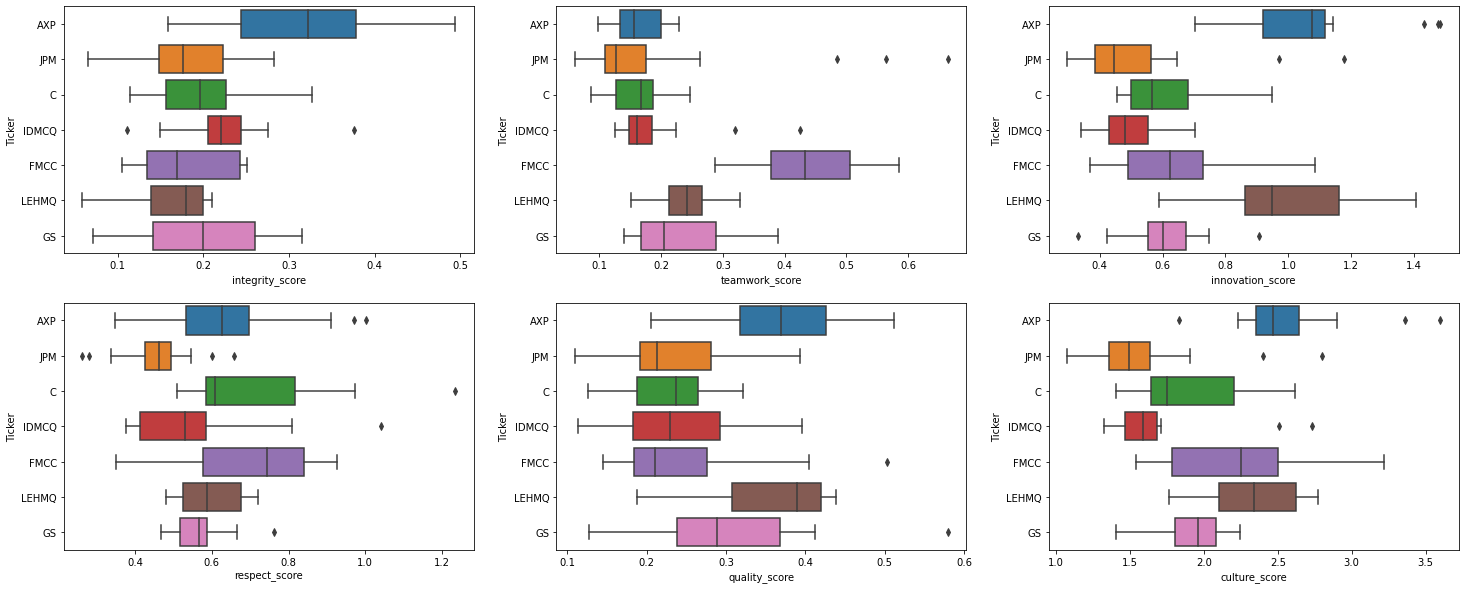

In [60]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

sns.boxplot(x='integrity_score', y='Ticker', data=X_plot, ax=axs[0, 0]);
sns.boxplot(x='teamwork_score', y='Ticker', data=X_plot, ax=axs[0, 1]);
sns.boxplot(x='innovation_score', y='Ticker', data=X_plot, ax=axs[0, 2]);
sns.boxplot(x='respect_score', y='Ticker', data=X_plot, ax=axs[1, 0]);
sns.boxplot(x='quality_score', y='Ticker', data=X_plot, ax=axs[1, 1]);
sns.boxplot(x='culture_score', y='Ticker', data=X_plot, ax=axs[1, 2]);

In [61]:
X_plot = X

The next plot groups the banks into 2 buckets failed/non-failed and, with a boxplot, shows the values ranges / distributions of the culture scores. The boxplots hint at: 
- The quality score & innovation score seem to have the most significant relationship with failure risk (looking at the significantly smaller median of failed banks vs. non-failed)
- The culture score (sum of the 5 distinct scores) seems to hint at an association (looking at the smaller median of failed banks vs. non-failed)
- For integrity, teamwork and respect it is hard to infer an association

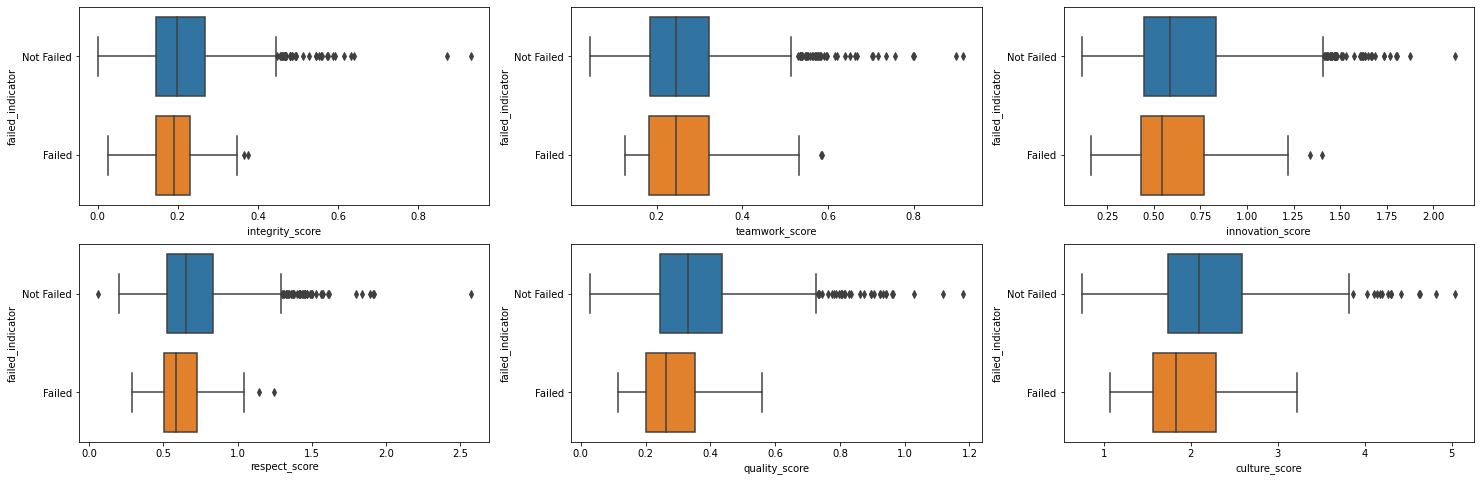

In [62]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 8))

sns.boxplot(x='integrity_score', y='failed_indicator', data=X_plot, ax=axs[0, 0]);
sns.boxplot(x='teamwork_score', y='failed_indicator', data=X_plot, ax=axs[0, 1]);
sns.boxplot(x='innovation_score', y='failed_indicator', data=X_plot, ax=axs[0, 2]);
sns.boxplot(x='respect_score', y='failed_indicator', data=X_plot, ax=axs[1, 0]);
sns.boxplot(x='quality_score', y='failed_indicator', data=X_plot, ax=axs[1, 1]);
sns.boxplot(x='culture_score', y='failed_indicator', data=X_plot, ax=axs[1, 2]);

Plot the distribution of failed vs. non-failed banks in the dataset.

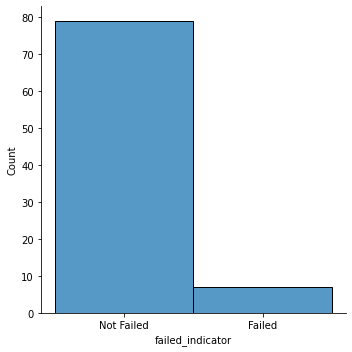

In [63]:
sns.displot(data=X.groupby('Ticker').max(), x='failed_indicator');

## Tops und Flops in the period leading up to the financial crisis
In this section, I want to examine if the failed banks have had a high occurrance in the top- or flop-buckets concerning the single culture scores. A high (low) occurrence in the Flop (Top) ranks would hint at an association between culture and failure risk. Obviously, this approach is very heuristic and should be understood as a first try to get a sense for the question being asked. It will not be sufficient to derive strong statements about the relationship between the variables.

### group dataframe to create summary statistics

In [64]:
df_grouped = X[['CompanyName', 'Ticker', 'integrity_score', 'teamwork_score', 'innovation_score', 'respect_score', 'quality_score', 'culture_score',
                'failed_indicator']].groupby(['Ticker', 'CompanyName', 'failed_indicator']).mean().reset_index().set_index(['Ticker', 'CompanyName'])
df_grouped.head()

,,failed_indicator,integrity_score,teamwork_score,innovation_score,respect_score,quality_score,culture_score
Ticker,CompanyName,,,,,,,
0176A,MUFG Americas Holdings Corp,Not Failed,0.189780,0.372298,0.376932,0.585879,0.301256,1.826145
AMTD,TD Ameritrade Holding Corp,Not Failed,0.237220,0.244504,0.694242,0.641764,0.398495,2.216225
AXP,American Express Co,Not Failed,0.317444,0.165681,1.057487,0.646513,0.377627,2.564751
BAC,Bank of America Corp,Not Failed,0.160799,0.205025,0.591781,0.470517,0.303259,1.731381
BANR,Banner Corp,Not Failed,0.163935,0.226808,0.327902,0.618914,0.193902,1.531461


In [65]:
n = 10  # number of tops and flops extracted
flops_failed = 0  # counter for failed companies in flop lists
tops_failed = 0  # counter for failed companies in top lists

### integrity

#### flops

In [66]:
score_name = 'integrity_score'
df_show = df_grouped.sort_values(score_name)[:n][['failed_indicator', score_name]]
print('Amount of flop', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
flops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of flop 10 failed... 0


,,failed_indicator,integrity_score
Ticker,CompanyName,,
SBNY,Signature Bank,Not Failed,0.089951
STT,State Street Corp,Not Failed,0.120698
CPF,Central Pacific Financial Corp,Not Failed,0.140171
FBC,Flagstar Bancorp Inc,Not Failed,0.141150
DCOM,Dime Community Bancshares Inc,Not Failed,0.142740
CMA,Comerica Inc,Not Failed,0.142853
SF,Stifel Financial Corp,Not Failed,0.144232
WIBC,Wilshire Bancorp Inc,Not Failed,0.148504
PRAA,PRA Group Inc,Not Failed,0.148536


#### tops

In [67]:
score_name = 'integrity_score'
df_show = df_grouped.sort_values(score_name, ascending=False)[:n][['failed_indicator', score_name]]
print('Amount of top', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
tops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of top 10 failed... 0


,,failed_indicator,integrity_score
Ticker,CompanyName,,
NTRS,Northern Trust Corp,Not Failed,0.531276
INDB,Independent Bank Corp (Massachusetts),Not Failed,0.398237
UMBF,UMB Financial Corp,Not Failed,0.338868
BPFH,Boston Private Financial Holdings Inc,Not Failed,0.329453
CBU,Community Bank System Inc,Not Failed,0.318079
AXP,American Express Co,Not Failed,0.317444
USB,U.S. Bancorp,Not Failed,0.309986
UCBI,United Community Banks Inc,Not Failed,0.308592
WL,Wilmington Trust Corp,Not Failed,0.296246


### teamwork

#### flops

In [68]:
score_name = 'teamwork_score'
df_show = df_grouped.sort_values(score_name)[:n][['failed_indicator', score_name]]
print('Amount of flop', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
flops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of flop 10 failed... 0


,,failed_indicator,teamwork_score
Ticker,CompanyName,,
WTFC,Wintrust Financial Corp,Not Failed,0.119367
MTB,M&T Bank Corp,Not Failed,0.159730
C,Citigroup Inc,Not Failed,0.161527
AXP,American Express Co,Not Failed,0.165681
GBCI,Glacier Bancorp Inc,Not Failed,0.171815
PBCT,People's United Financial Inc,Not Failed,0.179593
USB,U.S. Bancorp,Not Failed,0.184742
UMPQ,Umpqua Holdings Corp,Not Failed,0.187528
SIVB,SVB Financial Group,Not Failed,0.189013


#### tops

In [69]:
score_name = 'teamwork_score'
df_show = df_grouped.sort_values(score_name, ascending=False)[:n][['failed_indicator', score_name]]
print('Amount of top', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
tops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of top 10 failed... 1


,,failed_indicator,teamwork_score
Ticker,CompanyName,,
MKTX,Marketaxess Holdings Inc,Not Failed,0.459587
FMCC,Federal Home Loan Mortgage Corp,Failed,0.441465
ITG,Virtu Itg Holdings LLC,Not Failed,0.429548
BRKL,Brookline Bancorp Inc,Not Failed,0.411372
FCF,First Commonwealth Financial Corp,Not Failed,0.408775
UMBF,UMB Financial Corp,Not Failed,0.395387
CME,CME Group Inc,Not Failed,0.377922
FFBC,First Financial Bancorp,Not Failed,0.375773
0176A,MUFG Americas Holdings Corp,Not Failed,0.372298


### innovation

#### flops

In [70]:
score_name = 'innovation_score'
df_show = df_grouped.sort_values(score_name)[:n][['failed_indicator', score_name]]
print('Amount of flop', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
flops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of flop 10 failed... 1


,,failed_indicator,innovation_score
Ticker,CompanyName,,
MTB,M&T Bank Corp,Not Failed,0.291902
WRLD,World Acceptance Corp,Not Failed,0.302609
DCOM,Dime Community Bancshares Inc,Not Failed,0.318026
BANR,Banner Corp,Not Failed,0.327902
MBFI,MB Financial Inc,Not Failed,0.327963
SFNC,Simmons First National Corp,Not Failed,0.338136
FMBI,First Midwest Bancorp Inc,Not Failed,0.372384
0176A,MUFG Americas Holdings Corp,Not Failed,0.376932
WAFD,Washington Federal Inc,Failed,0.377218


#### tops

In [71]:
score_name = 'innovation_score'
df_show = df_grouped.sort_values(score_name, ascending=False)[:n][['failed_indicator', score_name]]
print('Amount of top', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
tops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of top 10 failed... 1


,,failed_indicator,innovation_score
Ticker,CompanyName,,
ITG,Virtu Itg Holdings LLC,Not Failed,1.463999
UMBF,UMB Financial Corp,Not Failed,1.420939
LUK2,Jefferies Group LLC,Not Failed,1.340127
MKTX,Marketaxess Holdings Inc,Not Failed,1.229146
CME,CME Group Inc,Not Failed,1.104995
AXP,American Express Co,Not Failed,1.057487
INTL,INTL FCStone Inc,Not Failed,1.043801
BK,Bank of New York Mellon Corp,Not Failed,1.033617
SWS,SWS Group Inc,Not Failed,1.005756


### respect

#### flops

In [72]:
score_name = 'respect_score'
df_show = df_grouped.sort_values(score_name)[:n][['failed_indicator', score_name]]
print('Amount of flop', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
flops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of flop 10 failed... 1


,,failed_indicator,respect_score
Ticker,CompanyName,,
MTB,M&T Bank Corp,Not Failed,0.369533
PBCT,People's United Financial Inc,Not Failed,0.443509
JPM,JPMorgan Chase & Co,Not Failed,0.455102
BAC,Bank of America Corp,Not Failed,0.470517
HBAN,Huntington Bancshares Inc,Not Failed,0.480204
GBCI,Glacier Bancorp Inc,Not Failed,0.515836
VLY,Valley National Bancorp,Not Failed,0.517136
TCBI,Texas Capital Bancshares Inc,Not Failed,0.520901
WAFD,Washington Federal Inc,Failed,0.521625


#### tops

In [73]:
score_name = 'respect_score'
df_show = df_grouped.sort_values(score_name, ascending=False)[:n][['failed_indicator', score_name]]
print('Amount of top', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
tops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of top 10 failed... 0


,,failed_indicator,respect_score
Ticker,CompanyName,,
SWS,SWS Group Inc,Not Failed,1.149350
FRC,First Republic Bank,Not Failed,1.136108
NTRS,Northern Trust Corp,Not Failed,1.126753
LUK2,Jefferies Group LLC,Not Failed,1.072349
WL,Wilmington Trust Corp,Not Failed,1.051585
BPFH,Boston Private Financial Holdings Inc,Not Failed,1.049331
UMBF,UMB Financial Corp,Not Failed,1.042580
INDB,Independent Bank Corp (Massachusetts),Not Failed,1.001477
STBA,S&T Bancorp Inc,Not Failed,0.951832


### quality

#### flops

In [74]:
score_name = 'quality_score'
df_show = df_grouped.sort_values(score_name)[:n][['failed_indicator', score_name]]
print('Amount of flop', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
flops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of flop 10 failed... 1


,,failed_indicator,quality_score
Ticker,CompanyName,,
DCOM,Dime Community Bancshares Inc,Not Failed,0.133104
MTB,M&T Bank Corp,Not Failed,0.164551
BANR,Banner Corp,Not Failed,0.193902
COF,Capital One Financial Corp,Not Failed,0.209371
GBCI,Glacier Bancorp Inc,Not Failed,0.213757
HBHC,Hancock Whitney Corp,Not Failed,0.216663
NYCB,New York Community Bancorp Inc,Not Failed,0.220130
BOH,Bank of Hawaii Corp,Not Failed,0.224289
VLY,Valley National Bancorp,Not Failed,0.225492


#### tops

In [75]:
score_name = 'quality_score'
df_show = df_grouped.sort_values(score_name, ascending=False)[:n][['failed_indicator', score_name]]
print('Amount of top', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
tops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of top 10 failed... 0


,,failed_indicator,quality_score
Ticker,CompanyName,,
WFC,Wells Fargo & Co,Not Failed,0.671322
MKTX,Marketaxess Holdings Inc,Not Failed,0.669335
ETFC,E*TRADE Financial Corp,Not Failed,0.601103
WL,Wilmington Trust Corp,Not Failed,0.556375
UMBF,UMB Financial Corp,Not Failed,0.556199
USB,U.S. Bancorp,Not Failed,0.547309
FRC,First Republic Bank,Not Failed,0.545292
CME,CME Group Inc,Not Failed,0.502498
STT,State Street Corp,Not Failed,0.480639


### culture

#### flops

In [76]:
score_name = 'culture_score'
df_show = df_grouped.sort_values(score_name)[:n][['failed_indicator', score_name]]
print('Amount of flop', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
flops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of flop 10 failed... 1


,,failed_indicator,culture_score
Ticker,CompanyName,,
MTB,M&T Bank Corp,Not Failed,1.146057
GBCI,Glacier Bancorp Inc,Not Failed,1.511374
DCOM,Dime Community Bancshares Inc,Not Failed,1.528357
BANR,Banner Corp,Not Failed,1.531461
JPM,JPMorgan Chase & Co,Not Failed,1.578814
PBCT,People's United Financial Inc,Not Failed,1.578857
SFNC,Simmons First National Corp,Not Failed,1.616058
WAFD,Washington Federal Inc,Failed,1.620749
MBFI,MB Financial Inc,Not Failed,1.657303


#### tops

In [77]:
score_name = 'culture_score'
df_show = df_grouped.sort_values(score_name, ascending=False)[:n][['failed_indicator', score_name]]
print('Amount of top', str(n), 'failed...', str(df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()))
tops_failed += df_show[df_show['failed_indicator'] == 'Failed']['failed_indicator'].count()
df_show

Amount of top 10 failed... 0


,,failed_indicator,culture_score
Ticker,CompanyName,,
UMBF,UMB Financial Corp,Not Failed,3.753974
MKTX,Marketaxess Holdings Inc,Not Failed,3.420706
ITG,Virtu Itg Holdings LLC,Not Failed,3.353796
LUK2,Jefferies Group LLC,Not Failed,3.145091
SWS,SWS Group Inc,Not Failed,3.048002
INDB,Independent Bank Corp (Massachusetts),Not Failed,2.992101
NTRS,Northern Trust Corp,Not Failed,2.987364
BK,Bank of New York Mellon Corp,Not Failed,2.902497
FRC,First Republic Bank,Not Failed,2.841461


## Result
We can see that while failed companies had a higher (2 times higher) occurrance in the flop lists which hints at an association between culture and failure risk. Loosely speaking, the flops tend to fail more likely than the top companies. Again, this very heuristic approach should be seen as way to get some sense for the question being asked. This association could have easily also happened by chance.

In [78]:
print('Failed companies had ',flops_failed, ' occurrences in the flop', str(n), 'lists')
print('Failed companies had ',tops_failed, ' occurrences in the top', str(n), 'lists')

Failed companies had  4  occurrences in the flop 10 lists
Failed companies had  2  occurrences in the top 10 lists


## Probit-Regression
### y={failed, not failed}, x=culture scores (mean per entity)

In [79]:
X_regression = X.copy()
X_regression['year'] = X_regression['date'].map(lambda x: x.year)
X_regression = X_regression.drop(['profitability', 'integrity_count', 'teamwork_count', 'innovation_count', 'respect_count', 'quality_count'], axis=1).dropna()
X_regression.head()

,CompanyName,Ticker,date,integrity_score,teamwork_score,innovation_score,respect_score,quality_score,culture_score,failed_indicator,year
0,American Express Co,AXP,2005-01-24 22:00:00+00:00,0.377033,0.183130,0.947969,0.635570,0.420123,2.563826,Not Failed,2005
1,American Express Co,AXP,2005-10-24 21:00:00+00:00,0.326664,0.214373,1.143324,0.612495,0.377705,2.674561,Not Failed,2005
2,American Express Co,AXP,2005-04-26 21:00:00+00:00,0.480523,0.194254,1.431346,1.001943,0.490747,3.598814,Not Failed,2005
3,American Express Co,AXP,2005-07-25 21:00:00+00:00,0.494378,0.222955,0.949981,0.911206,0.319891,2.898410,Not Failed,2005
4,American Express Co,AXP,2006-04-24 16:00:00+00:00,0.316841,0.146234,0.743359,0.536193,0.487448,2.230076,Not Failed,2006


In [80]:
# group the culture scores on the level of full years
X_regression = X_regression.groupby(['CompanyName', 'Ticker', 'year']).mean().reset_index()
X_regression.head()

,CompanyName,Ticker,year,integrity_score,teamwork_score,innovation_score,respect_score,quality_score,culture_score
0,American Express Co,AXP,2005,0.419650,0.203678,1.118155,0.790303,0.402117,2.933903
1,American Express Co,AXP,2006,0.303471,0.139620,1.001445,0.563406,0.375181,2.383124
2,American Express Co,AXP,2007,0.288307,0.139651,1.279350,0.599934,0.430734,2.737976
3,American Express Co,AXP,2008,0.258346,0.179774,0.831000,0.632407,0.302476,2.204002
4,Bank of America Corp,BAC,2005,0.151790,0.216629,0.537695,0.466722,0.329354,1.702190


In the heatmap below, one can also see that all single culture scores are correlated positively. Moreover, the highest correlation seems to be between innovation_score and quality_score. On the other hand, teamwork_score and integrity_score show the weakest correlation.

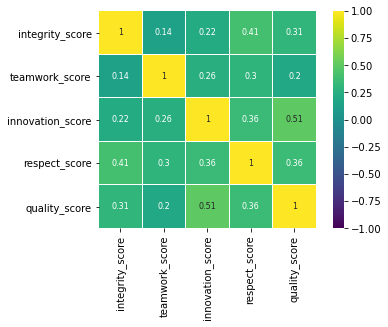

In [81]:
sns.heatmap(X_regression.drop(['culture_score', 'year'], axis=1).corr(), cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [82]:

from statsmodels.discrete.discrete_model import Probit

X_data = X_regression[['integrity_score', 'teamwork_score', 'innovation_score', 'respect_score', 'quality_score']]
X_data = sm.add_constant(X_data)
y_data = X_regression['Ticker'].map(lambda x: 1 if x in failed else 0)

model = Probit(y_data, X_data)
probit_model = model.fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.231639
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                 Ticker   No. Observations:                  319
Model:                         Probit   Df Residuals:                      313
Method:                           MLE   Df Model:                            5
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.1058
Time:                        17:18:04   Log-Likelihood:                -73.893
converged:                       True   LL-Null:                       -82.633
Covariance Type:            nonrobust   LLR p-value:                  0.003673
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1731      0.602     -0.288      0.774      -1.352       1.006
integrity_s

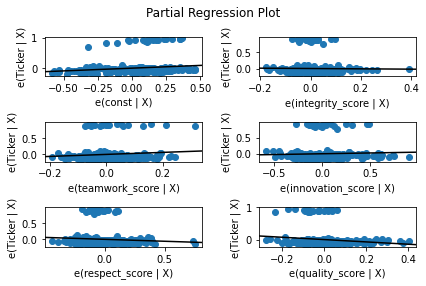

In [83]:
fig = sm.graphics.plot_partregress_grid(probit_model)
fig.tight_layout(pad=1.0)

In [84]:

X_data = X_regression[['culture_score']]
X_data = sm.add_constant(X_data)
y_data = X_regression['Ticker'].map(lambda x: 1 if x in failed else 0)

model = Probit(y_data, X_data)
probit_model = model.fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.251784
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                 Ticker   No. Observations:                  319
Model:                         Probit   Df Residuals:                      317
Method:                           MLE   Df Model:                            1
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                 0.02800
Time:                        17:18:05   Log-Likelihood:                -80.319
converged:                       True   LL-Null:                       -82.633
Covariance Type:            nonrobust   LLR p-value:                   0.03145
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4516      0.496     -0.911      0.362      -1.423       0.520
culture_score    -0.

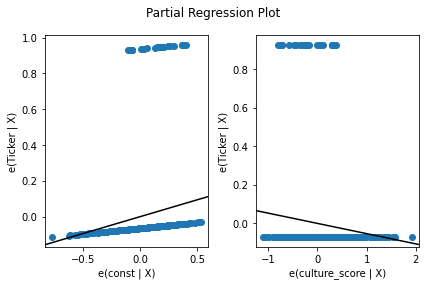

In [85]:
fig = sm.graphics.plot_partregress_grid(probit_model)
fig.tight_layout(pad=1.0)

### Regression Results

The regression results should definitely be checked for correctness. This first and foremost applies the specification of what a "failed bank" is. During the financial crisis, many banks failed but some in the end survived due to a bailout by a third party. Other banks did not receive a bailout and went into bankruptcy or were merged. But there were also banks that did not receive bailouts and thus cannot be considered failed. As this definition is crucial to the results of the regression and the correctness of our derived statement about the relationship between the variables, this section can only be looked at as a starting point for deeper analysis.

Moreover, the same logic applies also to the measurement of the culture scores. As I wrote in the beginning of the section, Li et al derived the culture scores using a different weighting scheme when counting the words in the dictionary. Further analysis should also consider different derivation techniques and look at how those map to the relationship between the variables.

If we now look into the first Probit-regression, we can see that the estimates for the coefficients of teamwork_score and innovation_score are positive while the estimates for quality_score, respect_score and integrity_score are negative. A negative relationship would hint at a decrease in failure risk if the respective culture attribute has a higher value, vice versa for a positive relation. As potential explanation for the positive association in the Probit regression, observe that Lehman scores high on innovation while FMCC scores high on teamwork. 

Moreover, the variable quality_score seems to have the strongest and most significant relationship (negative) with the probability of failue. All other association do not appear to be statistically significant.

If we look into the second Probit regression we can observe a statistically significant (5% level) negative association between the sum of all 5 distinct culture scores (named: culture_score) and the probability of failure. This results does make intuitive sense and stenghens our assumption that a relationship between corporate culture and failure risk exists.

To conclude, the data hints at an association (plots and regression) between the culture and the failure risk, but the answer cannot be answered fully at this stage, as a deeper dive into the derivation of the input data appears to be necessary.


# Text Similarity
The similarity measure is the measure of how much alike two data objects are. A similarity measure is a data mining or machine learning context is a distance with dimensions representing features of the objects. If the distance is small, the features are having a high degree of similarity. Whereas a large distance will be a low degree of similarity. Generally, similarity are measured in the range 0 to 1 [0,1]. 

### In the class + guest lectures we have looked at a range of different techniques to measure that similarity:
A rather broad distinction can be made between similarity algorithms that need a numerical vector representation of a document in order to measure similarity and those that do not require that:

Examples for similarity measures that receice the text (or tokens of text) as a string input are Jaccard similarity and levenshtein distance.

On the other hand, some measures require the text to be transformed to a numerical vector. In this case, measuring the similarity is a two-step process:
1. Deriving a numerical vector representation of the texts.
- The different texts / documents in a corpus will be converted into a common vector space
- This can be achieved with a simple BoW Model or with more sophisticated techniques like word embeddings
2. Choosing the distance function on the common vector space
- In a second step, the documents' vectors will be mapped by a pre-defined distance function (i.e. a norm on vector space) to a distance
- The lower the distance the higher the similarity
- This distance function can have forms (Cosine Similarity, L1-Norm, L2-Norm, etc...)

Moreover one can look at another rather high-level distinction  between different approaches:
1) Algorithms that only look at the lexical similarity. Those methods typically do not take into account the actual meaning behind words or the entire phrase in context. (Jaccard similarity, Bag of Words, TF-IDF)
2) Algorithms trying to measure semantic similarity. That means that these algorithms also try to learn and infer the context of words or documents. These include the family of word2vec and doc2vec models.

In the following section, I will try to find an answer to the question: Which management teams have the most similar language to the man- agement of Lehman Brothers? I will examine different approaches:
- Jaccard similarity 
- TF-IDF vectorization + similarity measure: cosine similarity
- Self-trained doc2vec model + similarity measure: cosine similarity

At the beginning of each section I will shortly introduce some notes on the respective approaches.

In [86]:
# restrict tickers
X_sim = df_workfile.copy()#[df_workfile['Ticker'].isin(tickers)]
X_sim.shape

(2029, 18)

## levenshtein distance 
So far we have been introduced to the similarity measures that will be applied in the following section. The first one that I would like to discuss is the Levenshtein distance. 

The Levenshtein distance between 2 strings is defined as the minimum number of operations needed to convert one string to another. To me, looking at the construction of the Levenshtein distance, this approach does not seem to be applicable to the question being asked here as we deal with large amounts of text instead of single words / sentences.

In [87]:
#!pip install strsimpy
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

normalized_levenshtein = NormalizedLevenshtein()
print(normalized_levenshtein.distance('shine', 'train'))

# 4 instructions out of 5 characters

0.8


In [88]:
print(normalized_levenshtein.distance('AI is our friend and it has been friendly', 'AI and humans have always been friendly'))

0.4634146341463415


## Jaccard similarity

The Jaccard similarity of 2 documents is defined as: the size of the intersection of the words in both documents divided by the combined set of words in both documents.

Advantage:
- Easy to understand, implement and compute
- No training of any model needed

Disadvantage:
- If you look at a simple example from the guest lecture (also shown below)
    - sentences: s0 = 'Obama speaks in Illinois', s1 = 'President greets the press in Chicago'
    - If 2 sentences have no common words they will have a Jaccard similarity score of 0. In this example the score of 0 is obviously very bad as the sentences have similar meanings. Here Jaccard similarity is neither able to capture semantic similarity nor lexical semantic of these two sentences.
- Moreover, as the size of documents increase, this approach has an inherent flaw. That is with a increasing number of words the number of common words tend to increase even if the documents talk about different topics.

How it is implemented in my notebook:
- For Jaccard similarity, I will first preprocess the calls (including the deletion of stopwords and lemmatization (to reduce words to the same root word)). Then I will call a function to calculate the jaccard similarity of all calls included in the dataset with all Lehman calls.

In [89]:
X_jacc = X_sim.copy()
X_jacc.head(3)

,date,CompanyName,at,bkvlps,ceq,dvt,gp,ni,revt,mkvalt,filename,Ticker,raw_body,text,presentation,Q&A,presentation share,profitability
0,2005-01-24 22:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1002205_T.xml,AXP,Q4 2004 American Express Company Earnings Conf...,good afternoon. my name is miles and i will be...,good afternoon. my name is miles and i will be...,thank you. we will now begin the question-and-...,0.315667,0.146679
1,2005-10-24 21:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1151089_T.xml,AXP,Q3 2005 American Express Company Earnings Conf...,"good afternoon. my name is derek, and i will b...","good afternoon. my name is derek, and i will b...","(operator instructions). bruce harting, lehman...",0.317339,0.146679
2,2005-04-26 21:00:00+00:00,American Express Co,113960.0,8.5004,10549.0,596.0,5262.0,3734.0,25457.0,63861.86,1055317_T.xml,AXP,Q1 2005 American Express Company Earnings Conf...,"at this time, i would like to welcome everyone...","at this time, i would like to welcome everyone...","(operator instructions). michael cohen, susque...",0.284373,0.146679


In [90]:
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def preprocess_jaccard(conference_call):
    """This function takes in a conference call text file and preprocesses it in a way to make it usable for jaccard similarity analysis. The goal is to clean 
    the text, but perform stemming in order to recognize the same words in diffent forms as the same (for jaccard similarity). 

    Args:
        conference_call ([string]): String of presentation and Q&A section

    Returns:
        [list of strings]: cleaned, stemmed, tokenized earnings call
    """
    # remove stop words from conference call text file
    call_without_stop_words = remove_stopwords(conference_call)

    # use gensim preprocess function to tokenize and clean text
    call_cleaned = simple_preprocess(call_without_stop_words)

    # perform stemming on every token
    call_cleaned_stemmed = [wnl.lemmatize(token) for token in call_cleaned]
    
    return call_cleaned_stemmed
    

In [91]:
# preprocess all earnings calls according to jaccard preprocessing function
X_jacc['jacc_tokenized'] = X_jacc['text'].parallel_map(lambda x: preprocess_jaccard(x))

In [92]:
def jaccard_similarity(query, document):
    """The function takes in 2 tokenized and cleaned text documents and calculates the jaccard similarity of the documents. A high value maps to a high similarity 
    between the documents.

    Args:
        query ([list of tokens]): list of tokens object for which the similarity to document is queried.
        document ([list of tokens]): list of tokens

    Returns:
        [float]: jaccard similarity (the higher the returned value, the more similar the 2 documents)
    """
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

# examples from the guest lecture
print('Example 1', jaccard_similarity(preprocess_jaccard('AI is our friend and it has been friendly') , 
                    preprocess_jaccard('AI and humans have always been friendly')))
print('Example 2', jaccard_similarity(preprocess_jaccard('Obama speaks in Illinois') , 
                    preprocess_jaccard('President greets the press in Chicago')))

Example 1 0.5
Example 2 0.0


Important note: 

In all of my compare_to_lehman functions that I implemented in this section, the similarity measures of all calls (rows in workfile dataframe) to single Lehman calls will be saved in a dataframe column. The columns will be named "similarity to <IDX_OF_LEHMAN_CALL_IN_X_sim_DATAFRAME>". So the number refers to the index of the single Lehman calls inside the dataframe X_sim: For example "1350" refers to the Lehman earnings call on "2005-12-13 14:30:00+00:00".

In [93]:
def compare_to_lehman_jaccard():
    """this function compares every Lehman brothers earnings call with any other call. The similarity will be calculated based on jaccard similarity.

    Returns:
        [dataframe]: dataframes contains a summary of all jaccard similarities between all earnings calls and the lehman calls.
    """
    df_sim_summary = X_jacc[['CompanyName', 'Ticker', 'date', 'text']].copy()

    # loop through all earnings calls of lehman (if not leahman -> continue)
    for i, row in X_jacc.iterrows():
        if row['Ticker'] != 'LEHMQ':
            continue
        query = row['jacc_tokenized'] 
        # loop through all calls and calculate jacc similarity of these with lehman call 
        for j, row1 in X_jacc.iterrows():
            document = row1['jacc_tokenized'] 
            jacc_sim = jaccard_similarity(query, document)
            df_sim_summary.loc[j, 'similarity to {}'.format(str(i))] = jacc_sim

    return df_sim_summary

In [94]:
df_jacc_summary = compare_to_lehman_jaccard()

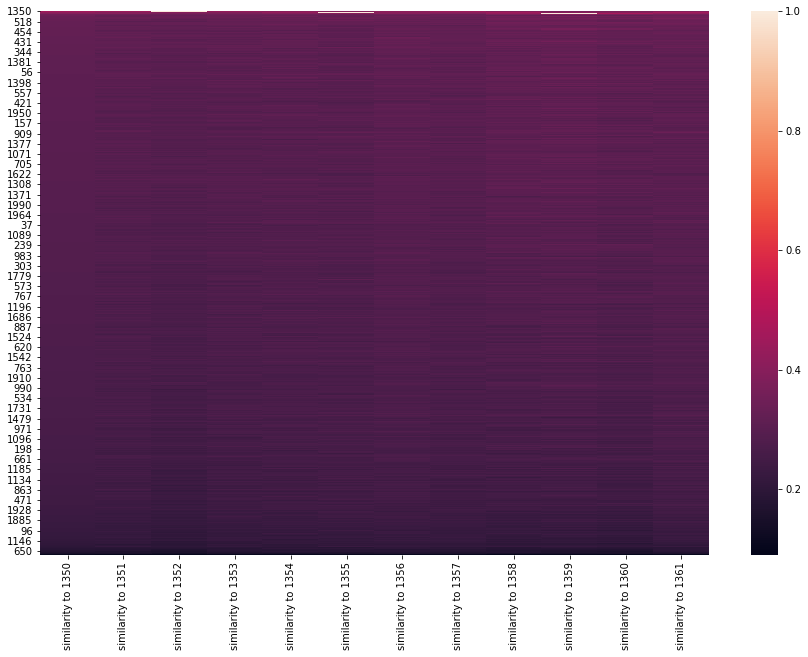

In [95]:
plt.figure(figsize=(15,10))
sns.heatmap(df_jacc_summary[['similarity to 1350',
       'similarity to 1351', 'similarity to 1352', 'similarity to 1353',
       'similarity to 1354', 'similarity to 1355', 'similarity to 1356',
       'similarity to 1357', 'similarity to 1358', 'similarity to 1359',
       'similarity to 1360', 'similarity to 1361']].sort_values('similarity to 1350', ascending=False));

In [96]:
df_jacc_summary.drop('text', axis=1).sort_values('similarity to 1350', ascending=False).head(20)

,CompanyName,Ticker,date,similarity to 1350,similarity to 1351,similarity to 1352,similarity to 1353,similarity to 1354,similarity to 1355,similarity to 1356,similarity to 1357,similarity to 1358,similarity to 1359,similarity to 1360,similarity to 1361
1350,Lehman Brothers Holdings Inc,LEHMQ,2005-12-13 14:30:00+00:00,1.000000,0.442794,0.459008,0.442394,0.403587,0.417714,0.440181,0.475839,0.402509,0.394016,0.385152,0.405935
1357,Lehman Brothers Holdings Inc,LEHMQ,2006-03-15 14:30:00+00:00,0.475839,0.421613,0.442488,0.436385,0.411902,0.416667,0.444119,1.000000,0.406385,0.387298,0.368528,0.407773
1352,Lehman Brothers Holdings Inc,LEHMQ,2005-09-14 13:30:00+00:00,0.459008,0.444626,1.000000,0.427632,0.408129,0.391449,0.412829,0.442488,0.397317,0.373267,0.375000,0.397245
1351,Lehman Brothers Holdings Inc,LEHMQ,2005-06-14 13:30:00+00:00,0.442794,1.000000,0.444626,0.462029,0.413634,0.399538,0.433084,0.421613,0.405782,0.397715,0.391415,0.407917
1353,Lehman Brothers Holdings Inc,LEHMQ,2005-03-15 14:30:00+00:00,0.442394,0.462029,0.427632,1.000000,0.396281,0.390187,0.433333,0.436385,0.388919,0.372732,0.373846,0.408533
1356,Lehman Brothers Holdings Inc,LEHMQ,2006-06-12 14:00:00+00:00,0.440181,0.433084,0.412829,0.433333,0.432188,0.403938,1.000000,0.444119,0.416297,0.401604,0.387755,0.413405
1355,Lehman Brothers Holdings Inc,LEHMQ,2006-12-14 16:00:00+00:00,0.417714,0.399538,0.391449,0.390187,0.425479,1.000000,0.403938,0.416667,0.450088,0.399561,0.401955,0.453174
1361,Lehman Brothers Holdings Inc,LEHMQ,2007-06-12 14:00:00+00:00,0.405935,0.407917,0.397245,0.408533,0.429009,0.453174,0.413405,0.407773,0.470175,0.418362,0.416712,1.000000
1354,Lehman Brothers Holdings Inc,LEHMQ,2006-09-13 14:00:00+00:00,0.403587,0.413634,0.408129,0.396281,1.000000,0.425479,0.432188,0.411902,0.417185,0.389309,0.381432,0.429009
1358,Lehman Brothers Holdings Inc,LEHMQ,2007-03-14 14:00:00+00:00,0.402509,0.405782,0.397317,0.388919,0.417185,0.450088,0.416297,0.406385,1.000000,0.426646,0.434536,0.470175


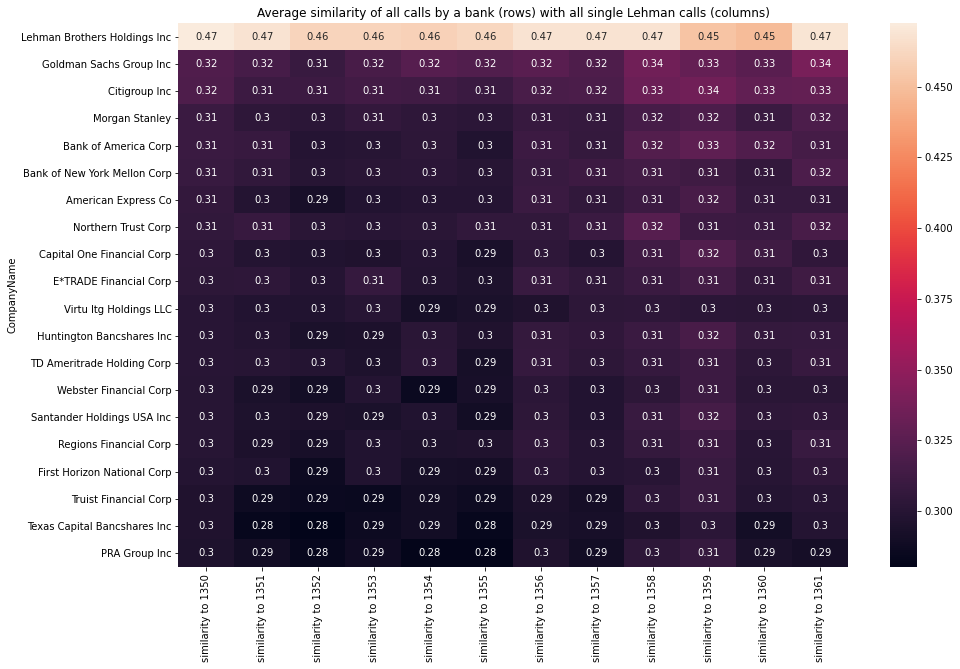

In [97]:
df_jacc_grouped = df_jacc_summary.groupby('CompanyName').mean().sort_values('similarity to 1350', ascending=False)
plt.figure(figsize=(15,10))
sns.heatmap(df_jacc_grouped.head(20), annot=True);
plt.title('Average similarity of all calls by a bank (rows) with all single Lehman calls (columns)');

Result: Measured by jaccard similarity the management teams of the following banks have the most similar language compared to LEHMQ.

Mean over mean-similarity of all calls of one specific bank with all Lehman calls, averaged over all Lehman calls (grouped per entity).

In [98]:
df_jacc_result = df_jacc_grouped.mean(axis=1).sort_values(ascending=False)[:20]
df_jacc_result

CompanyName
Lehman Brothers Holdings Inc             0.463224
Goldman Sachs Group Inc                  0.323443
Citigroup Inc                            0.320033
Bank of America Corp                     0.310079
Morgan Stanley                           0.309031
Northern Trust Corp                      0.308439
Bank of New York Mellon Corp             0.307544
E*TRADE Financial Corp                   0.305586
American Express Co                      0.304362
Capital One Financial Corp               0.303620
Huntington Bancshares Inc                0.303329
TD Ameritrade Holding Corp               0.302571
Regions Financial Corp                   0.300731
Santander Holdings USA Inc               0.300584
Virtu Itg Holdings LLC                   0.299313
Webster Financial Corp                   0.298372
First Horizon National Corp              0.298298
SVB Financial Group                      0.296935
Federal National Mortgage Association    0.296186
Comerica Inc                          

## conversion to numerical vectors
In the following section I will use 2 different methods to vectorize the earnings calls. After vectorizing I will again search for the calls and thus management teams that are most similar to those of Lehman.

### tf-idf vectorization
The tf-idf vectorization, we have discussed multiple times in the lecture. The final output for one document inside a corpus (here one call inside the corpus consisting of the collecrtion of all calls) is a vector that contains the tf-idf measure for all words that are part of the document. For words that did not occurred in the document the value of the vector in that dimension will be 0. The tf-idf matrix consists of all document vectors as rows and the words as columns (dimensions of the vector space). 

The cosine similarity based on tf-idf vectorization is likely to be a more appropriate measure of similarity in contrast to Jaccard similarity as it weights the importance of a keyword phrase by comparing it to the frequency of the term in a large set of documents, instead of treating every word equally.

Nevertheless, also the tf-idf vectorization does not account for the meaning of words or sentences in a context and is solely based on words (without context).

The implementation is explained in more detail below.

In [99]:
X_sim_idf = X_sim.copy()

In [100]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/lukas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [101]:
from gensim import corpora
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def tokenize_tf_idf(conference_call):
    """This function takes in a conference call text file and preprocesses it in a way to make it usable for a TF-IDF analysis. The goal is to 
    clean the text, but also to reduce inflectional forms by lemmatization and the deletion of stopwords. This is done in order to reduce the dimensionality of 
    the TF-IDF matrix and also to increase the accuracy of the analysis.

    Args:
        conference_call ([string]): text file of one conference call

    Returns:
        [list]: tokenized, cleaned text 
    """

    # remove stop words from conference call text file
    call_without_stop_words = remove_stopwords(conference_call)

    # use gensim preprocess function to tokenize and clean text
    call_cleaned = simple_preprocess(call_without_stop_words)

    # perform stemming on every token
    call_cleaned_lemmatized= [wnl.lemmatize(token) for token in call_cleaned]
    
    return call_cleaned_lemmatized
    

#### Implementation in gensim
For the implementation I will use the gensim library. I chose to do so because gensim works very efficient, especially with large amounts of text. Given the relatively large number and lenght of the documents we have in our corpus the implementation is way smoother and faster in gensim compared to many other standard libraries. The primary reason for this is that gensim is memory independent - it does not need to have the whole corpus in memory at once.

Tokenize all texts and save it to a list containing docs

In [102]:
# tokenize every presentation text according to function that is defined above
X_sim_idf['tf_idf_tokenized'] = X_sim_idf['presentation'].parallel_map(lambda x: tokenize_tf_idf(x))

# save all tf-idf-tokenized presentations to the list
doc_tokenized = X_sim_idf['tf_idf_tokenized'].tolist()

Use an instance of a gensim dictionary to save the information which words appear in the whole corpus (collection of all earnings calls). Moreover the function doc2bow returns a list of 2-tuples that contain an index of a word in the dictionary and the count of occurrences in the document (single earnings call). This information is then stored as a list for all earnings calls.

In [103]:
dictionary = corpora.Dictionary()

BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]


In this section the genism Tfidf model is fitted on the BoW corpus. 

In [104]:
from gensim.models import TfidfModel
from gensim import similarities

tfidf = TfidfModel(BoW_corpus, smartirs='ntc')

feature_cnt = len(dictionary.token2id)
feature_cnt

19868

Now we want to use the fitted Tfidf model in order to get the similarity of single documents in the corpus. This can be achieved using SparseMatrixSimilarity from gensim. We pass the fitted model with BoW corpus into it and get returned a SparseMatrixSimilarity/"index" instance on which we can perform queries. With these we can then easily query for the similarity of one text to all others. 

According to gensim's documentation, the similarity is calculated using the Cosine similarity as distance measure. (https://radimrehurek.com/gensim/similarities/docsim.html#gensim.similarities.docsim.SparseMatrixSimilarity )

In [105]:
# create index to query the tf-idf based cosine similarity
index = similarities.SparseMatrixSimilarity(tfidf[BoW_corpus], num_features = feature_cnt)

In [106]:
# test case to see if everything works
text0 = dictionary.doc2bow(doc_tokenized[0], allow_update=True)

similarity = index[tfidf[text0]]

sim = similarity
for i in range(len(sim)):
    #print('keyword is similar to text%d: %.2f' % (i + 1, sim[i]))
    pass

In [107]:
def compare_to_lehman_tf_idf():
    """This function creates a dataframe containing the summary of all the cosine similarities based on tf-idf model.

    Returns:
        [dataframe]: stores the similarity of all single calls to those of lehman brothers
    """
    
    # get metadata from X_sim_idf
    df_tf_idf_summary = X_sim_idf[['CompanyName', 'Ticker', 'date', 'text']].copy()

    # loop through all rows in dataframe aka single calls 
    for i, row in X_sim_idf.iterrows():
        # for all non-lehman calls continue with the next call
        if row['Ticker'] != 'LEHMQ':
            continue
        # extract tokenized call text from row
        text_tokenized = row['tf_idf_tokenized']
        # get the text encoded in 2-tuple way (like explained earlier (BoW_corpus))
        text_doc = dictionary.doc2bow(text_tokenized, allow_update=True)
        # query for the similarity of text_tokenized (one specific lehman call) to all other calls in the dataframe
        similarity = index[tfidf[text_doc]]

        # store the queried similarity vector in the dataframe
        df_tf_idf_summary['similarity to {}'.format(str(i))] = similarity

    return df_tf_idf_summary

In [108]:
df_tf_idf_summary = compare_to_lehman_tf_idf()

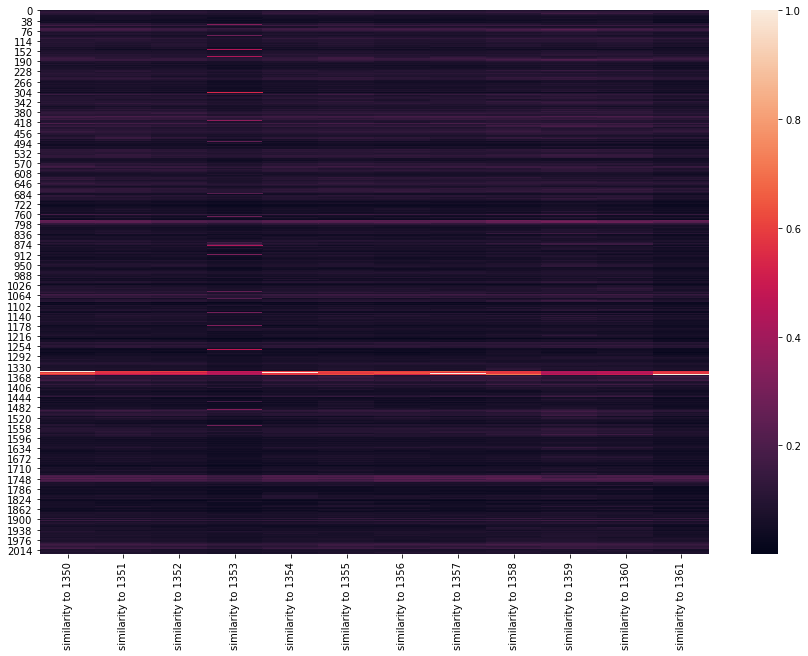

In [109]:
plt.figure(figsize=(15,10))
sns.heatmap(df_tf_idf_summary[['similarity to 1350',
       'similarity to 1351', 'similarity to 1352', 'similarity to 1353',
       'similarity to 1354', 'similarity to 1355', 'similarity to 1356',
       'similarity to 1357', 'similarity to 1358', 'similarity to 1359',
       'similarity to 1360', 'similarity to 1361']]);

In [110]:
df_tf_idf_summary.drop('text', axis=1).sort_values('similarity to 1350', ascending=False).head(20)

,CompanyName,Ticker,date,similarity to 1350,similarity to 1351,similarity to 1352,similarity to 1353,similarity to 1354,similarity to 1355,similarity to 1356,similarity to 1357,similarity to 1358,similarity to 1359,similarity to 1360,similarity to 1361
1350,Lehman Brothers Holdings Inc,LEHMQ,2005-12-13 14:30:00+00:00,1.000001,0.585955,0.594015,0.484360,0.587558,0.610974,0.597457,0.660986,0.589022,0.431568,0.467523,0.567091
1357,Lehman Brothers Holdings Inc,LEHMQ,2006-03-15 14:30:00+00:00,0.660986,0.561031,0.557141,0.467161,0.575798,0.582866,0.634255,1.000001,0.597691,0.414089,0.437809,0.579726
1355,Lehman Brothers Holdings Inc,LEHMQ,2006-12-14 16:00:00+00:00,0.610974,0.517386,0.517382,0.423658,0.590445,1.000000,0.574018,0.582866,0.650313,0.440703,0.493241,0.627035
1356,Lehman Brothers Holdings Inc,LEHMQ,2006-06-12 14:00:00+00:00,0.597457,0.572491,0.523570,0.449065,0.628539,0.574018,1.000001,0.634255,0.585073,0.447357,0.462459,0.532129
1352,Lehman Brothers Holdings Inc,LEHMQ,2005-09-14 13:30:00+00:00,0.594015,0.553386,1.000000,0.448918,0.512915,0.517382,0.523570,0.557141,0.509168,0.393346,0.407009,0.474627
1358,Lehman Brothers Holdings Inc,LEHMQ,2007-03-14 14:00:00+00:00,0.589022,0.544828,0.509168,0.425199,0.580010,0.650313,0.585073,0.597691,1.000000,0.538508,0.548468,0.713167
1354,Lehman Brothers Holdings Inc,LEHMQ,2006-09-13 14:00:00+00:00,0.587558,0.564388,0.512915,0.430197,1.000000,0.590445,0.628539,0.575798,0.580010,0.444987,0.455965,0.585745
1351,Lehman Brothers Holdings Inc,LEHMQ,2005-06-14 13:30:00+00:00,0.585955,1.000000,0.553386,0.510674,0.564388,0.517386,0.572491,0.561031,0.544828,0.456283,0.475433,0.489126
1361,Lehman Brothers Holdings Inc,LEHMQ,2007-06-12 14:00:00+00:00,0.567091,0.489126,0.474627,0.422730,0.585745,0.627035,0.532129,0.579726,0.713167,0.470362,0.498883,0.999999
1353,Lehman Brothers Holdings Inc,LEHMQ,2005-03-15 14:30:00+00:00,0.484360,0.510674,0.448918,1.000000,0.430197,0.423658,0.449065,0.467161,0.425199,0.335907,0.370124,0.422730


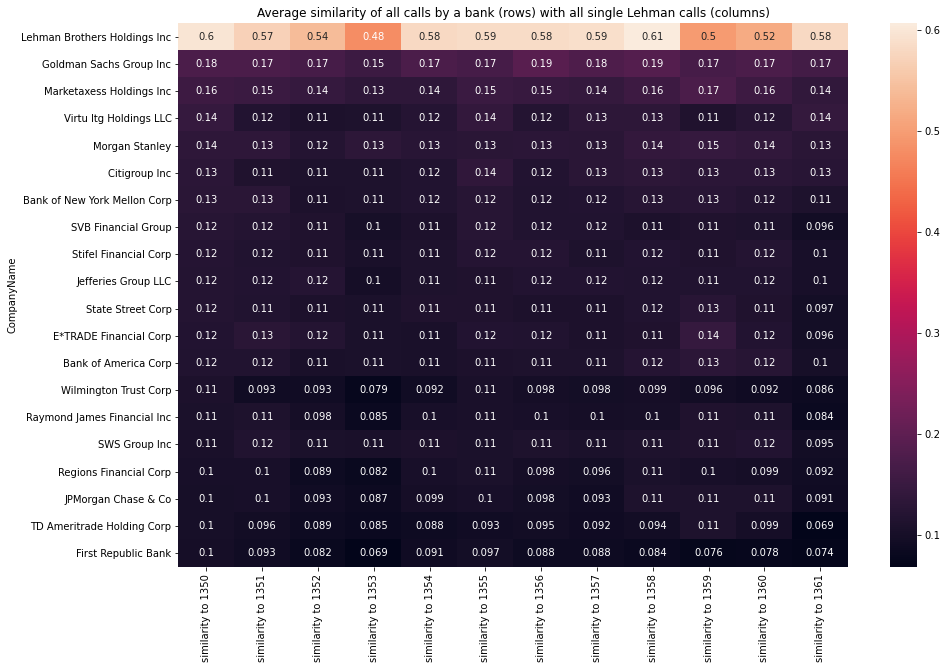

In [111]:
df_tf_idf_summary_grouped = df_tf_idf_summary.groupby('CompanyName').mean().sort_values('similarity to 1350', ascending=False)
plt.figure(figsize=(15,10))
sns.heatmap(df_tf_idf_summary_grouped.head(20), annot=True);
plt.title('Average similarity of all calls by a bank (rows) with all single Lehman calls (columns)');

Result: Measured by tf-idf vectorization and cosine similarity the management teams of the following banks have the most similar language compared to LEHMQ.

Mean over mean-similarity of all calls of one specific bank with all Lehman calls, averaged over all Lehman calls (grouped per entity).

In [112]:
df_tf_idf_result = df_tf_idf_summary_grouped.mean(axis=1).sort_values(ascending=False)[:20]
df_tf_idf_result

CompanyName
Lehman Brothers Holdings Inc             0.560736
Goldman Sachs Group Inc                  0.173509
Marketaxess Holdings Inc                 0.149216
Morgan Stanley                           0.132375
Virtu Itg Holdings LLC                   0.126293
Citigroup Inc                            0.124142
Bank of New York Mellon Corp             0.119682
E*TRADE Financial Corp                   0.116510
Stifel Financial Corp                    0.115197
Jefferies Group LLC                      0.114332
Bank of America Corp                     0.113730
State Street Corp                        0.113070
SVB Financial Group                      0.112904
SWS Group Inc                            0.108755
Federal Home Loan Mortgage Corp          0.107909
First Horizon National Corp              0.102534
U.S. Bancorp                             0.102413
Raymond James Financial Inc              0.102180
Federal National Mortgage Association    0.101993
JPMorgan Chase & Co                   

### doc2vec (semantic similarity)
Motivation: Many machine learning algorithms require the input to be represented as a fixed-length feature vector. When it comes to texts, one of the most common fixed-length features is bag-of-words. Despite their popularity, bag-of-words features have two major weaknesses: they lose the ordering of the words and they also ignore semantics of the words. For example, "powerful," "strong" and "Paris" are equally distant. 

The gensim doc2vec model consists of an unsupervised algorithm that learns fixed-length feature representations from variable-length pieces of texts, such as sentences, paragraphs, and documents. The algorithm represents each document by a dense vector which is trained to predict words in the document. Its construction gives the algorithm the potential to overcome the weaknesses of bag-of-words models. Empirical results show that Paragraph Vectors outperform bag-of-words models as well as other techniques for text representations. (https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html )



In [113]:
from gensim.models import doc2vec
X_sim_doc2vec = X_sim.copy()

In [114]:
def preprocess_doc2vec(conference_call):
    
    tokens = simple_preprocess(conference_call)

    return 

In [115]:
corpus = [doc2vec.TaggedDocument((simple_preprocess(conference_call)), [i]) for i, conference_call in enumerate(X_sim_doc2vec['presentation'].tolist())]

In [116]:
#corpus[:2]

#### model training
Now, we’ll instantiate a Doc2Vec model with a vector size with 50 dimensions and iterating over the training corpus 40 times. We set the minimum word count to 2 in order to discard words with very few occurrences.

Essentially, the vocabulary is a list (accessible via model.wv.index_to_key) of all of the unique words extracted from the training corpus. Additional attributes for each word are available using the model.wv.get_vecattr() method, For example, to see how many times penalty appeared in the training corpus:

In [117]:
model = doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(corpus)

In [118]:
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

Now, we can use the trained model to infer a vector for any piece of text by passing a list of words to the model.infer_vector function. This vector can then be compared with other vectors via cosine similarity.

In the next section I'll test if the model's results make intuitive sense. The first 2 examples will be very equal in their meaning, which should be mirrored in a small cosine distance / high cosine similarity. The third example will contain a very different meaning, which should result in a higher cosine distance / lower similarity.

In [119]:
# test the models given some very basic examples
vector = model.infer_vector(['lehman', 'brothers', 'is', 'failed'])
print(vector)
print(len(vector))
vector1 = model.infer_vector(['lehman', 'brothers', 'has', 'gone', 'bankrupt'])
print(vector1)
print(len(vector1))
vector2 = model.infer_vector(['i', 'love', 'gensim'])
print(vector2)
print(len(vector2))

[-0.3701495  -0.46995914 -0.3553741  -0.00825437  0.02262889  0.1567637
 -0.03248996  0.33717433 -0.5542585   0.1057799   0.11249062  0.9718597
 -0.3105948  -0.11096524 -0.14211608  0.07207942  0.11214722 -0.05618326
 -0.24835323  0.24901575 -0.05778746 -0.4813857  -0.5882576   0.25763535
  0.1344167   0.18789046  0.20603131 -0.8659212  -0.07751255 -0.45738238
 -0.48698482  0.00860196 -0.48322794 -0.21443014  0.29460782  0.5525963
 -0.36399445  0.16094334 -0.18102118 -0.74970573  0.36285278 -0.04251743
 -0.5090921  -0.12968527  0.09340654 -0.10214291  0.14315802  0.08441443
  0.20938072 -0.31041396]
50
[-0.30559912 -0.33283114 -0.41531938  0.3364     -0.08976589  0.35641447
 -0.06890041  0.139517   -0.48453075  0.01053463  0.21874793  0.45539147
 -0.5094032  -0.10629799 -0.13666624  0.12116306 -0.00357246  0.0602547
  0.06857549  0.5132611  -0.08450174 -0.24129981 -0.6209957   0.25605965
  0.14732464  0.03528275  0.3422007  -0.68337834 -0.5923654  -0.26150662
 -0.40870175  0.0510549  -

In [120]:
from scipy import spatial
print(round(spatial.distance.cosine(vector, vector1), 3))
print(round(spatial.distance.cosine(vector1, vector2), 3))
print(round(spatial.distance.cosine(vector, vector2), 3))

0.162
0.459
0.315


Looking at this basic test, the model behaves as expected.

Another test is proposed by the tutorial on https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py . To asses the quality of the model, I will loop over all documents that are included in the corpus that was used to train the model. For every document the we get the most similar document out of the corpus. If the model behaves as expected / was trained correctly the those 2 documents should be equal. If this is the case, we can see below... 

In [121]:
ranks = []

# loop through all documents in our corpus
for doc_id in range(len(corpus)):
    # get the document i transformed to a vector according to our model trained above
    inferred_vector = model.infer_vector(corpus[doc_id].words)
    # query for the similarity of the document i and all other documents in the corpus
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    # check if the index of the most similar document in corpus for document i matches the document i's index
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

In [122]:
import collections

counter = collections.Counter(ranks)
print(counter)

Counter({0: 2027, 1: 2})


Also when looking at this test, the model behaves as expected. 2027 presentations have been mapped correctly, only 2 incorrectly.

In the next setion I will try to extract the most similar calls to those of Lehman.

In [123]:
def compare_to_lehman_doc2vec():
    """This function creates a dataframe containing the summary of all the cosine similarities based on doc2vec model.

    Returns:
        [dataframe]: stores the similarity of all single calls to those of lehman brothers
    """
    
    # get metadata from X_sim_idf
    df_doc2vec_summary = X_sim_doc2vec[['CompanyName', 'Ticker', 'date', 'text']].copy()

    # loop through all rows in dataframe aka single calls 
    for i, row in X_sim_doc2vec.iterrows():
        # for all non-lehman calls continue with the next call
        if row['Ticker'] != 'LEHMQ':
            continue
        # extract tokenized call text from row (Tagged Document instance)
        corpus_i = corpus[i]
    
        # get the document i transformed to a vector according to our model trained above
        inferred_vector = model.infer_vector(corpus_i.words)
        # query for the similarity of the document i and all other documents in the corpus
        sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))  # list of tuples containing (id of TaggedDocument, model-implied cosine similarity)
        # sort the similarity list according to index in order to match the dataframe's index below
        sims.sort()
        # create a list containing only similarity values
        similarity = [sim for docid, sim in sims]  

        # store the similarity vector in the dataframe
        df_doc2vec_summary['similarity to {}'.format(str(i))] = similarity

    return df_doc2vec_summary

In [124]:
df_doc2vec_summary = compare_to_lehman_doc2vec()


Plot a heatmap to get a better overview of the calculated similarity measures.

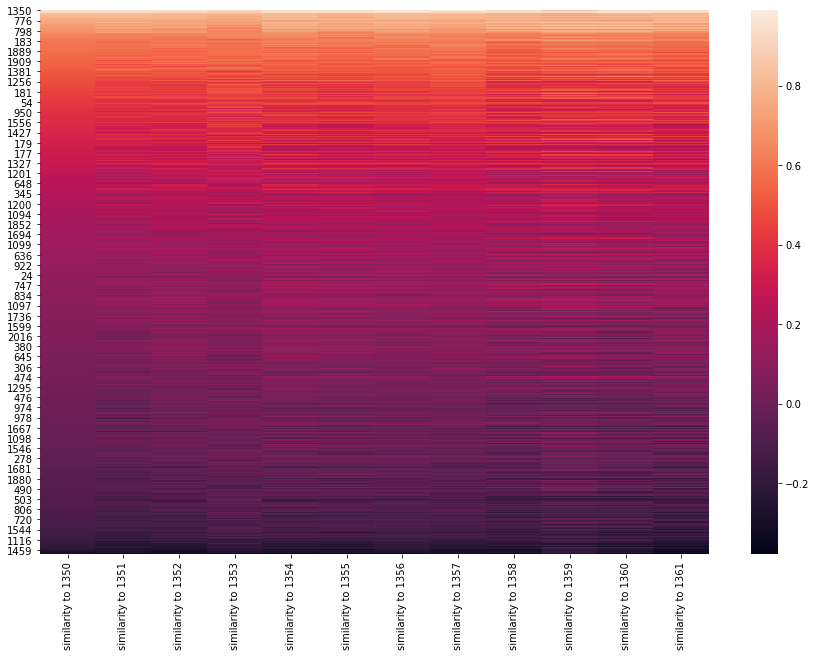

In [125]:
plt.figure(figsize=(15,10))
sns.heatmap(df_doc2vec_summary[['similarity to 1350',
       'similarity to 1351', 'similarity to 1352', 'similarity to 1353',
       'similarity to 1354', 'similarity to 1355', 'similarity to 1356',
       'similarity to 1357', 'similarity to 1358', 'similarity to 1359',
       'similarity to 1360', 'similarity to 1361']].sort_values('similarity to 1350', ascending=False));

In [126]:
df_doc2vec_summary.drop('text', axis=1).sort_values('similarity to 1350', ascending=False).head(20)

,CompanyName,Ticker,date,similarity to 1350,similarity to 1351,similarity to 1352,similarity to 1353,similarity to 1354,similarity to 1355,similarity to 1356,similarity to 1357,similarity to 1358,similarity to 1359,similarity to 1360,similarity to 1361
1350,Lehman Brothers Holdings Inc,LEHMQ,2005-12-13 14:30:00+00:00,0.981744,0.949987,0.947764,0.910931,0.936232,0.948760,0.950702,0.954710,0.922644,0.864503,0.903402,0.937404
1352,Lehman Brothers Holdings Inc,LEHMQ,2005-09-14 13:30:00+00:00,0.960778,0.949478,0.987889,0.917239,0.954874,0.960167,0.940699,0.967450,0.919790,0.868186,0.917787,0.935418
1357,Lehman Brothers Holdings Inc,LEHMQ,2006-03-15 14:30:00+00:00,0.958378,0.947002,0.954924,0.917519,0.950169,0.958428,0.948402,0.987383,0.930630,0.870808,0.914925,0.946505
1353,Lehman Brothers Holdings Inc,LEHMQ,2005-03-15 14:30:00+00:00,0.958172,0.935950,0.939973,0.988766,0.921816,0.934409,0.937107,0.951098,0.895652,0.847249,0.897147,0.915516
1351,Lehman Brothers Holdings Inc,LEHMQ,2005-06-14 13:30:00+00:00,0.956841,0.989620,0.950051,0.910330,0.948913,0.946900,0.959143,0.947242,0.946575,0.897173,0.929270,0.941822
1355,Lehman Brothers Holdings Inc,LEHMQ,2006-12-14 16:00:00+00:00,0.944215,0.936976,0.937086,0.896434,0.962263,0.988696,0.952575,0.947482,0.942494,0.882600,0.920696,0.959035
1356,Lehman Brothers Holdings Inc,LEHMQ,2006-06-12 14:00:00+00:00,0.942046,0.941208,0.920880,0.900201,0.959794,0.956072,0.987167,0.935152,0.945141,0.899993,0.926834,0.943863
1361,Lehman Brothers Holdings Inc,LEHMQ,2007-06-12 14:00:00+00:00,0.938184,0.934487,0.918405,0.881395,0.951317,0.977905,0.960290,0.939662,0.960249,0.910925,0.933336,0.984193
1354,Lehman Brothers Holdings Inc,LEHMQ,2006-09-13 14:00:00+00:00,0.927198,0.933436,0.932714,0.874996,0.985888,0.960971,0.960371,0.938882,0.940651,0.892699,0.928866,0.937080
1358,Lehman Brothers Holdings Inc,LEHMQ,2007-03-14 14:00:00+00:00,0.919122,0.941510,0.907122,0.858153,0.952148,0.952389,0.958607,0.927229,0.983270,0.932041,0.940270,0.957346


##### Results

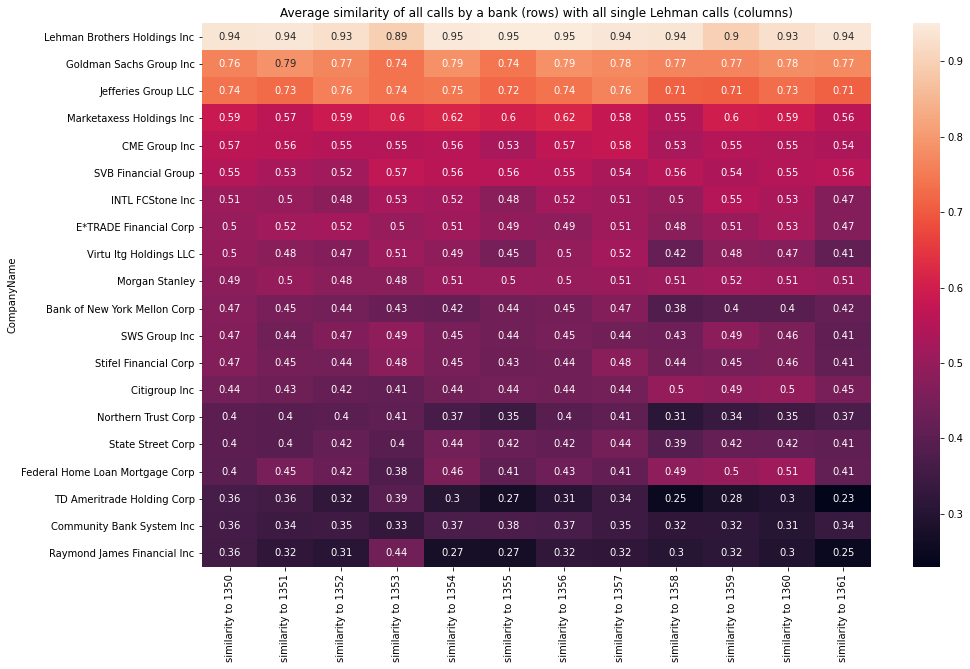

In [127]:
df_doc2vec_summary_grouped = df_doc2vec_summary.groupby('CompanyName').mean().sort_values('similarity to 1350', ascending=False)
plt.figure(figsize=(15,10))
sns.heatmap(df_doc2vec_summary_grouped.head(20), annot=True);
plt.title('Average similarity of all calls by a bank (rows) with all single Lehman calls (columns)');

In [128]:
df_doc2_vec_result = df_doc2vec_summary_grouped.mean(axis=1).sort_values(ascending=False)[:20]
df_doc2_vec_result

CompanyName
Lehman Brothers Holdings Inc             0.933079
Goldman Sachs Group Inc                  0.769744
Jefferies Group LLC                      0.732415
Marketaxess Holdings Inc                 0.588830
CME Group Inc                            0.552699
SVB Financial Group                      0.548359
INTL FCStone Inc                         0.509741
E*TRADE Financial Corp                   0.503225
Morgan Stanley                           0.500810
Virtu Itg Holdings LLC                   0.474509
SWS Group Inc                            0.452155
Citigroup Inc                            0.450676
Stifel Financial Corp                    0.449133
Federal Home Loan Mortgage Corp          0.439481
Bank of New York Mellon Corp             0.429690
State Street Corp                        0.414447
Federal National Mortgage Association    0.381580
Northern Trust Corp                      0.374596
Community Bank System Inc                0.343924
American Express Co                   

## Results and final remarks
According to the discussion below, it should be expected that the most accurate results stem from the doc2vec model. In the following section I would like to give a short overview about the results all 3 methods while centering it around doc2vec.

If one looks into the next cells, one can make the following observations:
- Given the top 20 most similar banks to Lehman for each method, TFIDF and doc2vec have 16 banks in common which appears to be a very high number
- Also jaccard similarity and doc2vec agree on 12 of the top 20 most similar banks which is a lower number but still relatively high, given that they use profoundly different concepts behind the implementation

- Moreover, all 3 methods include many of those banks that have a quite similar business model within the banking sector to that which Lehman had. Namely they agree on: Goldman Sachs, Citigroup Inc, Morgan Stanley, Bank of New York Mellon, Bank of America. This definitely makes intuitive sense as banks with highly similar business models tend to cope with similar challenges and are affected similarly by the market environment, thus resulting in similar language / content of the earnings calls. On the other hand JPMorgan Chase & Co would also fit in that set, but is only recognized by tfidf (and also on a rather low similarity level)

- Interestingly the doc2vec and tfidf model also includes 2 prominent failed banks in the top 20: Federal Home Loan Mortgage, Federal National Mortgage. Maybe, this could be a starting point for a further investigation of the relationship of text similarity and failure risk...

- On the other hand, Jefferies, Marketaxcess and CME Group are ranked on the places 2-4 (when not considering Lehman itself in the ranks) according to doc2vec while none of the 3 appears in Jaccard. This underlines the difference in the concepts and thus results 


In [129]:
# get the most similar banks according to the 3 methods
top_doc2vec = set(df_doc2_vec_result.index)
top_tfidf = set(df_tf_idf_result.index)
top_jacc = set(df_jacc_result.index)

# derive the intersection 
print('Banks that both tfidf and doc2vec rank among the most similar...', top_doc2vec.intersection(top_tfidf), 'Amount:', len(top_doc2vec.intersection(top_tfidf)))
print('-----------------------------')
print('Banks that both jacc and doc2vec rank among the most similar...', top_doc2vec.intersection(top_jacc), 'Amount:', len(top_doc2vec.intersection(top_jacc)))
print('-----------------------------')
print('Banks that all 3 rank among the most similar...', top_doc2vec.intersection(top_jacc).intersection(top_tfidf), 'Amount:', len(top_doc2vec.intersection(top_jacc).intersection(top_tfidf)))

Banks that both tfidf and doc2vec rank among the most similar... {'Jefferies Group LLC', 'SWS Group Inc', 'SVB Financial Group', 'Stifel Financial Corp', 'Federal Home Loan Mortgage Corp', 'Federal National Mortgage Association', 'Virtu Itg Holdings LLC', 'Goldman Sachs Group Inc', 'Citigroup Inc', 'E*TRADE Financial Corp', 'Morgan Stanley', 'Lehman Brothers Holdings Inc', 'State Street Corp', 'Bank of New York Mellon Corp', 'Marketaxess Holdings Inc'} Amount: 15
-----------------------------
Banks that both jacc and doc2vec rank among the most similar... {'Bank of New York Mellon Corp', 'SVB Financial Group', 'Federal National Mortgage Association', 'Northern Trust Corp', 'Virtu Itg Holdings LLC', 'Goldman Sachs Group Inc', 'Citigroup Inc', 'E*TRADE Financial Corp', 'Morgan Stanley', 'Lehman Brothers Holdings Inc', 'American Express Co'} Amount: 11
-----------------------------
Banks that all 3 rank among the most similar... {'SVB Financial Group', 'Morgan Stanley', 'Virtu Itg Holding

The next cell prints the summary dataframe of the results of the 3 different methods:

In [130]:
df_result = pd.concat([df_doc2_vec_result, df_tf_idf_result, df_jacc_result], axis=1)
df_result.columns = ['doc2vec', 'TF-IDF', 'Jaccard Similarity']
df_result.sort_values('doc2vec', ascending=False)

,doc2vec,TF-IDF,Jaccard Similarity
Lehman Brothers Holdings Inc,0.933079,0.560736,0.463224
Goldman Sachs Group Inc,0.769744,0.173509,0.323443
Jefferies Group LLC,0.732415,0.114332,NaN
Marketaxess Holdings Inc,0.588830,0.149216,NaN
CME Group Inc,0.552699,NaN,NaN
SVB Financial Group,0.548359,0.112904,0.296935
INTL FCStone Inc,0.509741,NaN,NaN
E*TRADE Financial Corp,0.503225,0.116510,0.305586
Morgan Stanley,0.500810,0.132375,0.309031
Virtu Itg Holdings LLC,0.474509,0.126293,0.299313


Discussion End:
Looking at the results of the lectures and this notebook, one could agree on:

For less complicated similarity tasks the Jaccard similarity and the similarity based on tf-idf vectorization, representing rather trivial measures, can definitely do a good job. This, we have already seen in the lectures and also in this NB (for some simple examples).So if your computing resources are limited and you try to have a fast runtime of your algorithms, these methods may be a good choice and may serve as a first simple solution (maybe in a proof-of-concept way). On the same token, another advantage might be that the concepts behind the algorithms are easy to understand. This might serve you when debugging or when trying to understand the behavior of a certain application. On the other hand, models with an increased complexity behave more like black boxes (i.e. word2vec vectorization is based on neural networks) which, given that you are a beginner in this domain, make it hard for you to see problems and decide on which way to proceed in order to make your application better.

But if it comes to accuracy when dealing with more complex texts / words, the algorithms discussed above will probably not be sufficient any more. This, we have also seen in the lectures - if the similarity between 2 documents hides itself rather on a semantic than on a lexical level, you will also need to increase the complexity of your model. We looked at different word embedding techniques like word2vec that did a way better job than the trivial methods. 

Given this background and looking at the question of this case study, one can, first of all, note that the complexity of the texts is rather high. If you look at the texts, managements tackle a variety of different topics, including recent market developments, predictions for the future and how thier companies performed in this environment. To me, in such cases it seems unjustified to assume that lexical based algorithms can perform well on such data, as already small nuances can completely change the meaning of a word / sentence / paragraph. Moreover, it also seems natural that calls contain a lot of common vocabulary as the companies in the dataset are all in the same sector, so it should be expected that the Jaccard and TF-IDF algorithms do produce some clear outputs. But does that really map to the similarity that we would like to investigate? Based on the analysis in this notebook I would not negate the question, as the algorithm do produce consistent results over different calls from the same entity (compared with LEHMQ) and do not behave randomly. To answer this question fully, a deeper analysis will be needed.

But nonetheless, based on what we have learned in the lecture, it should be more promising to approach the question with a model, that also accounts for the context of single words / documents when embedding words / documents in a vector space. Again there was a very wide range of ways to proceed. I tested a set of different approaches, including pre-trained embedding models (which were mostly very slow thus not handy) and word2vec embeddings. To derive the vector for a whole text, from a word2vec model I used summation and averages. In the end I picked the way to train a doc2vec-model in gensim on our given corpus.According to gensim's documentation "Le and Mikolov in 2014 introduced the Doc2Vec algorithm, which usually outperforms such simple-averaging of Word2Vec vectors. (https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py)" I found this to be a matching method for our question. Thus, given the scope of the course and this case study, I would agree that this is one of the best ways to measure the similarity of the calls.